# Prediction of creditworthiness for credit card issuance.

The objective is the creation of a classifier, which is able to indicate the creditworthiness of new credit card applicants.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import  SMOTE
from imblearn.pipeline import Pipeline as IVPipeline

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import  StandardScaler
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from xgboost import XGBClassifier
import warnings

In [2]:
# --- Libraries Settings ---
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100

**Establish a seed to make the results reproducible.**

In [3]:
RANDOM_SEED = 0

**Import datasets**

In [4]:
# Read the 'application_record.csv' file into a DataFrame and assign it to ar_df
ar_df = pd.read_csv('application_record.csv')

# Read the 'credit_record.csv' file into another DataFrame and assign it to cr_df
cr_df = pd.read_csv('credit_record.csv')

# Pre-cleaning and merging of datasets

We call up the first five records of the dataframe ar (application_record), and study the different features of which it is composed.

In [5]:
ar_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


- **`ID`**: A unique identifier for each observation. This might be used to refer to each individual in the dataset without exposing sensitive personal information.
- **`CODE_GENDER`**: The gender of the individual, where "M" stands for male and "F" for female.
- **`FLAG_OWN_CAR`**: Indicates whether the individual owns a car. "Y" means yes, they own a car, while "N" indicates no.
- **`FLAG_OWN_REALTY`**: Indicates whether the individual owns real estate property. Again, "Y" stands for yes, and "N" for no.
- **`CNT_CHILDREN`**: The number of children the individual has.
- **`AMT_INCOME_TOTAL`**: The total income of the individual.
- **`NAME_INCOME_TYPE`**: The category of the individual's income type (e.g., "Working", "Commercial associate", etc.).
- **`NAME_EDUCATION_TYPE`**: The level of education of the individual (e.g., "Higher education", "Secondary / secondary special", etc.).
- **`NAME_FAMILY_STATUS`**: The family status of the individual (e.g., "Civil marriage", "Single / not married", "Married", etc.).
- **`NAME_HOUSING_TYPE`**: The type of housing the individual lives in (e.g., "Rented apartment", "House / apartment", etc.).
- **`DAYS_BIRTH`**: The age of the individual expressed in days, in negative numbers counted back from the current day (for example, "-12005" indicates that the individual was born 12005 days ago).
- **`DAYS_EMPLOYED`**: The number of days the individual has been employed, also expressed in negative values. Very high positive values often indicate particular situations like retirement or unemployment.
- **`FLAG_MOBIL`**: Indicates whether the individual owns a mobile phone, where "1" stands for yes.
- **`FLAG_WORK_PHONE`**: Indicates whether the individual has a work phone. "1" means yes and "0" means no.
- **`FLAG_PHONE`**: Indicates whether the individual has a landline phone. Here too, "1" for yes and "0" for no.
- **`FLAG_EMAIL`**: Indicates whether the individual uses an email. "1" for yes and "0" for no.
- **`OCCUPATION_TYPE`**: The type of occupation of the individual. For some observations, this may not be specified (NaN).
- **`CNT_FAM_MEMBERS`**: The total number of family members of the individual.

In [6]:
ar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [7]:
ar_df.shape

(438557, 18)

Specifically, ar_df consists of 438557 records and 18 features.

We can notice the presence of nulls in a feature. Let's recall it to find out the exact number of NaNs and how to work with them.

In [8]:
ar_df.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [9]:
ar_df.OCCUPATION_TYPE.isna().sum()/ar_df.shape[0]

0.30601039317580153

**OCCUPATION_TYPE** has 30% null values, too many to apply any substitutions. We will remove this feature from the DataFrame.

In [10]:
ar_df = ar_df.drop({"OCCUPATION_TYPE"},axis=1)

In [11]:
ar_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0


Calculate the number of duplicates in the dataframe and delete them.

In [12]:
# Calculate the number of rows before removing duplicates
rows_before_ar = ar_df.shape[0]

# Remove duplicates
ar_df = ar_df.drop_duplicates()

# Calculate the number of rows again after removal
rows_after_ar = ar_df.shape[0]

# Calculate the number of rows removed (duplicates)
duplicates_removed_ar = rows_before_ar - rows_after_ar

print(f"Duplicates removed: {duplicates_removed_ar}")

Duplicates removed: 0


In [13]:
ar_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [14]:
ar_df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,2.0


This code creates a 3x3 grid of subplots, where each cell in the grid shows a scatterplot of a particular variable against the ID in the ar_df dataframe. The variables include information such as number of children, total income amount, days of birth, days of employment, telephone indicators and number of family members. The points in the plot represent the relationship between the ID and each variable.

<Axes: xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

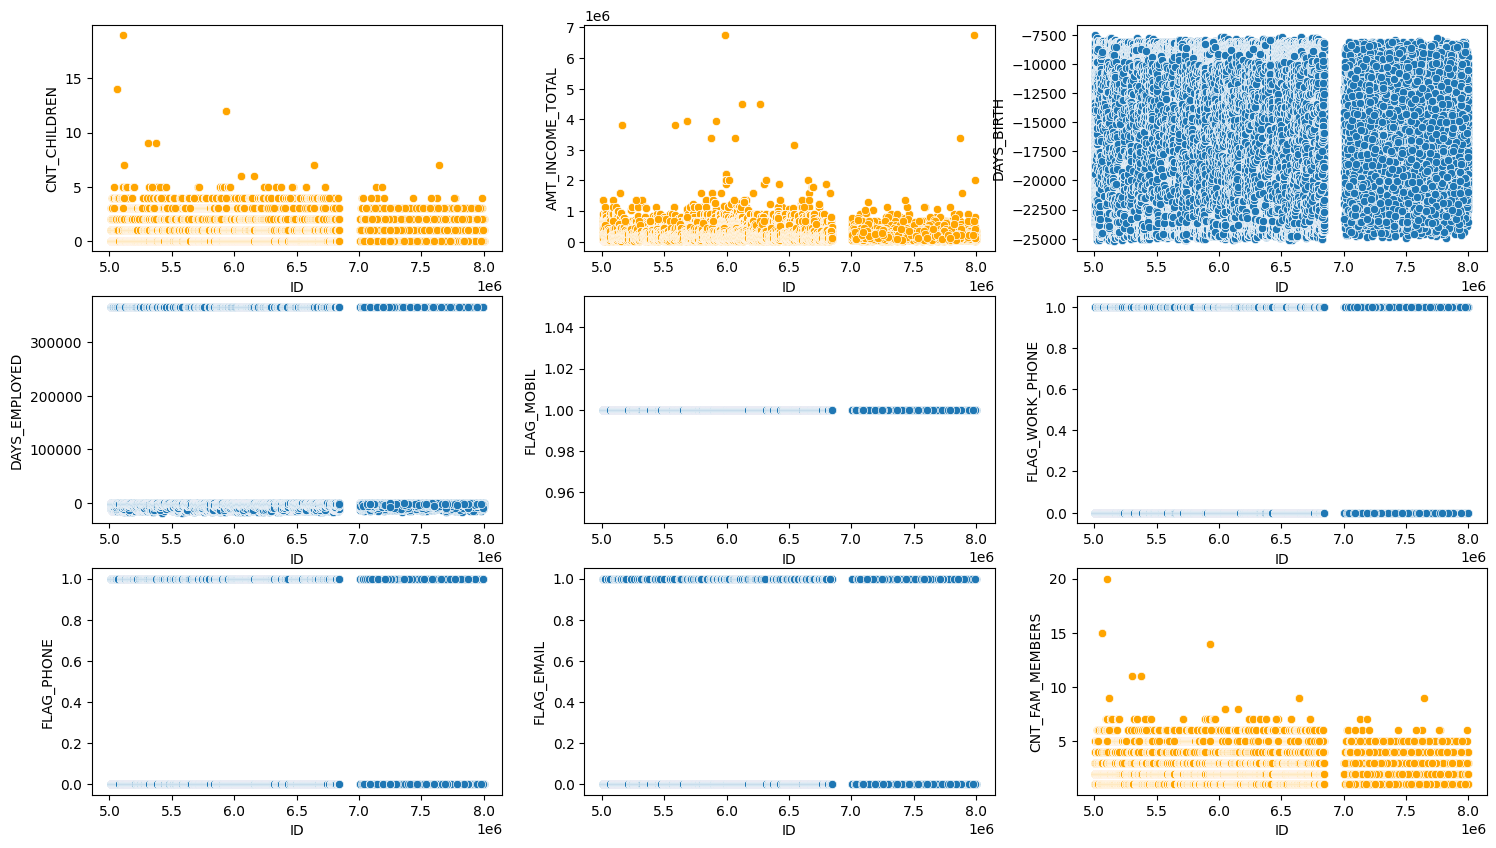

In [15]:
# Create a 3x3 subplot grid with a total size of 18x10 inches

fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (18,10))

# Plot a scatter plot of the variables variable against ID

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=ar_df, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=ar_df, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=ar_df, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=ar_df, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=ar_df, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=ar_df, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=ar_df, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=ar_df, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=ar_df, ax=ax[2][2], color= 'orange')

From the description and plots, outliers are evident in four features
 
- CNT_CHILDREN  
- AMT_INCOME_TOTAL  
- CNT_FAM_MEMBERS 
- DAYS_EMPLOYED

We need to remove these outliers to make sure they do not affect our model results. 

In [16]:
# Calculate the 99.9th percentile (q_hi) and the 0.1st percentile (q_low) of the column
q_hi = ar_df['CNT_CHILDREN'].quantile(0.999)
q_low = ar_df['CNT_CHILDREN'].quantile(0.001)

# Filter the DataFrame to keep rows where the variable is greater than q_low and less than q_hi

ar_df= ar_df[(ar_df['CNT_CHILDREN']>q_low) & (ar_df['CNT_CHILDREN']<q_hi)]

In [17]:
# FOR AMT_INCOME_TOTAL COLUMN
q_hi = ar_df['AMT_INCOME_TOTAL'].quantile(0.999)
q_low = ar_df['AMT_INCOME_TOTAL'].quantile(0.001)
ar_df= ar_df[(ar_df['AMT_INCOME_TOTAL']>q_low) & (ar_df['AMT_INCOME_TOTAL']<q_hi)]

In [18]:
#FOR DAYS_EMPLOYED COLUMN
q_hi = ar_df['DAYS_EMPLOYED'].quantile(0.999)
q_low = ar_df['DAYS_EMPLOYED'].quantile(0.001)
ar_df= ar_df[(ar_df['DAYS_EMPLOYED']>q_low) & (ar_df['DAYS_EMPLOYED']<q_hi)]

For CNT_FAM_MEMBERS we will replace the values above 6 with fashion, this is because the method of dropping outliers used with the other features gave problems in the execution, deleting important data.

In [19]:
# Calculation mode
moda = ar_df['CNT_FAM_MEMBERS'].mode()[0]

# Replacing values above 6 with mode
ar_df.loc[ar_df['CNT_FAM_MEMBERS'] >= 6, 'CNT_FAM_MEMBERS'] = moda

In [20]:
ar_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,1.310130e+05,131013.000000,131013.000000,131013.000000,131013.000000,131013.0,131013.000000,131013.000000,131013.000000,131013.000000
mean,6.020244e+06,1.380840,191021.356193,-13472.526368,-2355.098227,1.0,0.229855,0.257860,0.126140,3.249952
std,5.716722e+05,0.562527,98508.878566,2410.620294,1924.383015,0.0,0.420741,0.437458,0.332009,0.691144
min,5.008834e+06,1.000000,42750.000000,-23422.000000,-10883.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609540e+06,1.000000,126000.000000,-15081.000000,-3255.000000,1.0,0.000000,0.000000,0.000000,3.000000
50%,6.046939e+06,1.000000,171000.000000,-13359.000000,-1873.000000,1.0,0.000000,0.000000,0.000000,3.000000
75%,6.434483e+06,2.000000,225000.000000,-11609.000000,-894.000000,1.0,0.000000,1.000000,0.000000,4.000000
max,7.999952e+06,3.000000,990000.000000,-7859.000000,-12.000000,1.0,1.000000,1.000000,1.000000,5.000000


New scatterplot check, now free of outliers.

<Axes: xlabel='ID', ylabel='CNT_FAM_MEMBERS'>

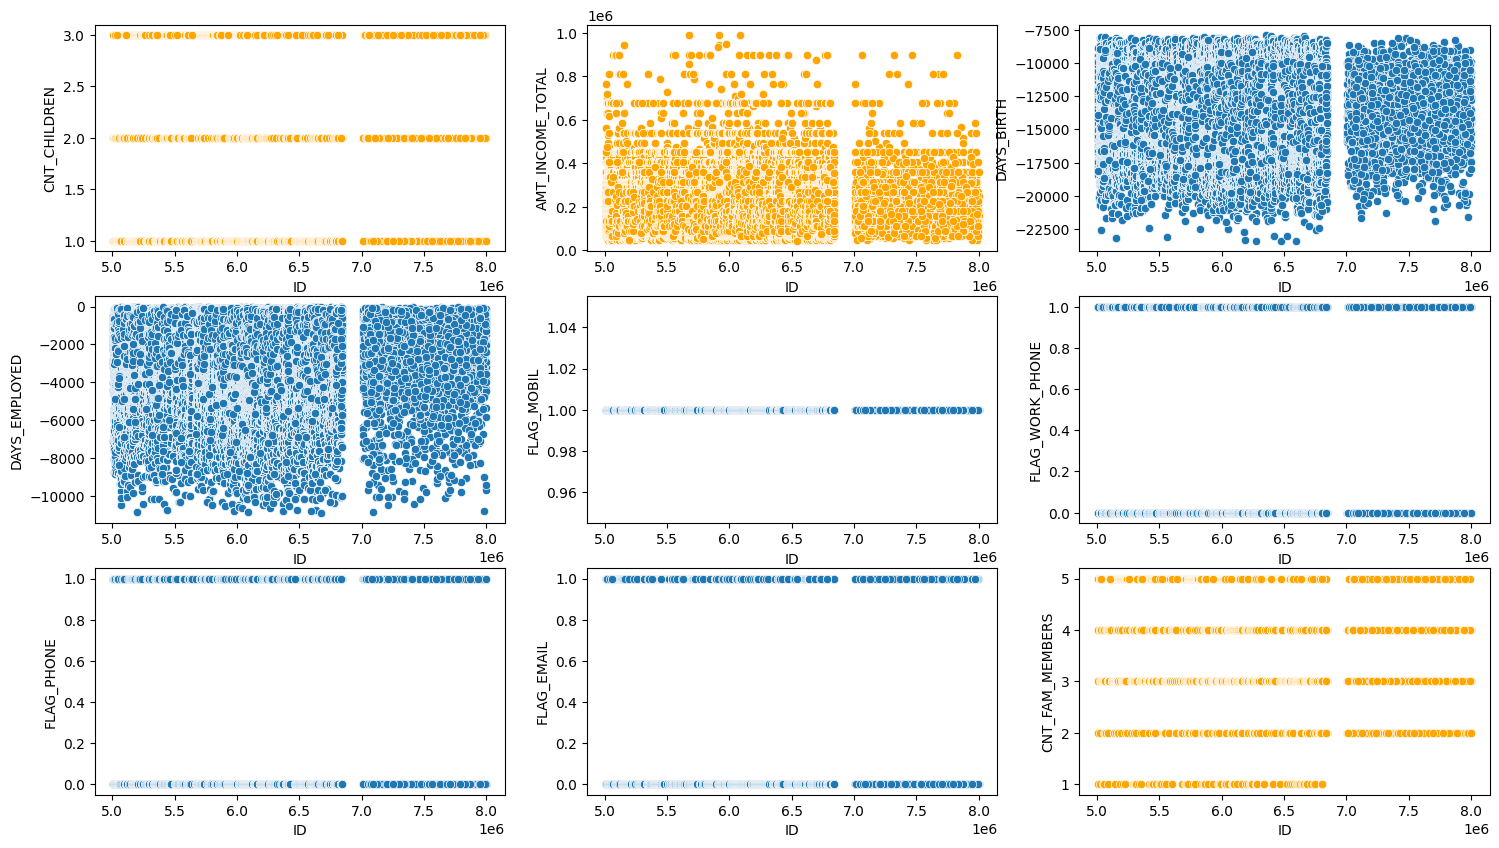

In [21]:
fig, ax= plt.subplots(nrows= 3, ncols = 3, figsize= (18,10))

sns.scatterplot(x='ID', y='CNT_CHILDREN', data=ar_df, ax=ax[0][0], color= 'orange')
sns.scatterplot(x='ID', y='AMT_INCOME_TOTAL', data=ar_df, ax=ax[0][1], color='orange')
sns.scatterplot(x='ID', y='DAYS_BIRTH', data=ar_df, ax=ax[0][2])
sns.scatterplot(x='ID', y='DAYS_EMPLOYED', data=ar_df, ax=ax[1][0])
sns.scatterplot(x='ID', y='FLAG_MOBIL', data=ar_df, ax=ax[1][1])
sns.scatterplot(x='ID', y='FLAG_WORK_PHONE', data=ar_df, ax=ax[1][2])
sns.scatterplot(x='ID', y='FLAG_PHONE', data=ar_df, ax=ax[2][0])
sns.scatterplot(x='ID', y='FLAG_EMAIL', data=ar_df, ax=ax[2][1])
sns.scatterplot(x='ID', y='CNT_FAM_MEMBERS', data=ar_df, ax=ax[2][2], color= 'orange')

It appears that all records have a value of 1 for FLAG_MOBIL, which means that all customers have mobile phones. We can therefore delete this characteristic as it does not give us any useful information for building the model.

In [22]:
ar_df = ar_df.drop({"FLAG_MOBIL"},axis=1)

In [23]:
ar_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,1.310130e+05,131013.000000,131013.000000,131013.000000,131013.000000,131013.000000,131013.000000,131013.000000,131013.000000
mean,6.020244e+06,1.380840,191021.356193,-13472.526368,-2355.098227,0.229855,0.257860,0.126140,3.249952
std,5.716722e+05,0.562527,98508.878566,2410.620294,1924.383015,0.420741,0.437458,0.332009,0.691144
min,5.008834e+06,1.000000,42750.000000,-23422.000000,-10883.000000,0.000000,0.000000,0.000000,1.000000
25%,5.609540e+06,1.000000,126000.000000,-15081.000000,-3255.000000,0.000000,0.000000,0.000000,3.000000
50%,6.046939e+06,1.000000,171000.000000,-13359.000000,-1873.000000,0.000000,0.000000,0.000000,3.000000
75%,6.434483e+06,2.000000,225000.000000,-11609.000000,-894.000000,0.000000,1.000000,0.000000,4.000000
max,7.999952e+06,3.000000,990000.000000,-7859.000000,-12.000000,1.000000,1.000000,1.000000,5.000000


In [24]:
cr_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


- **`MONTHS_BALANCE`**: Shows the month of the balance relative to the current date, where `0` indicates the current month, `-1` the previous month, and so on. This means the data are reported in a relative temporal format.
- **`STATUS`**: Indicates the balance status.  
**0:** 1-29 days past due;  
**1:** 30-59 days past due;  
**2:** 60-89 days overdue;  
**3:** 90-119 days overdue;  
**4** 120-149 days overdue;  
**5** overdue or bad debts, write-offs for more than 150 days;  
**C:** paid off that month;  
**X:** No loan for the month.

In [25]:
cr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [26]:
cr_df.shape

(1048575, 3)

cr_df consists of 1048575 records and 3 features. Check for double observations.

In [27]:
# Calculate the number of rows before removing duplicates
rows_before_cr = cr_df.shape[0]

# Remove duplicates
cr_df = cr_df.drop_duplicates()

# Calculate the number of rows again after removal
rows_after_cr = cr_df.shape[0]

# Calculate the number of rows removed (duplicates)
duplicates_removed_cr = rows_before_cr - rows_after_cr

print(f"Duplicates removed: {duplicates_removed_cr}")

Duplicates removed: 0


We study Status in more depth. We see that most customers pay their instalment with minimal delay, pay it on time or do not have to pay it for the month of interest.

In [28]:
cr_df['STATUS'].value_counts(normalize=True) * 100

STATUS
C    42.155401
0    36.537205
X    19.953747
1     1.057626
5     0.161457
2     0.082779
3     0.030518
4     0.021267
Name: proportion, dtype: float64

Looking at the percentages we can see that debtors are 1.353647% of the total. Counting them as belonging to classes 1 and upwards. We will subsequently soften this scale, counting as bad payers only those customers within a certain rank, which we will define later.

In [29]:
# Number of unique IDs in the application_record dataset
unique_ids_ar = ar_df['ID'].nunique()
total_rows_ar = ar_df.shape[0]
print(f"Unique IDs in application_record: {unique_ids_ar}")
print(f"Total rows in application_record: {total_rows_ar}")

# Number of unique IDs in the credit_record dataset
unique_ids_cr = cr_df['ID'].nunique()
total_rows_cr = cr_df.shape[0]
print(f"Unique IDs in credit_record: {unique_ids_cr}")
print(f"Total rows in credit_record: {total_rows_cr}")

Unique IDs in application_record: 131007
Total rows in application_record: 131013
Unique IDs in credit_record: 45985
Total rows in credit_record: 1048575


We can see that in both dataframes there are fewer IDs than total observations.  
Some customer IDs appear several times because the record refers to a different month - which can be seen via the feature **MONTHS_BALANCE**.

 
We will now create a merged dataset based on the ID.
 
 

In [30]:
def merge_by_ID(df_1, df_2):
  # First, the code calculates how many unique IDs are in each dataset and how many are shared
  unique_ids_df_1 = set(df_1['ID']) #These rows create a set of unique IDs in the 'ID' column of the dataframes
  unique_ids_df_2 = set(df_2['ID'])
  shared_ids = unique_ids_df_1.intersection(unique_ids_df_2) #Calculates the intersection between the unique ID sets of the two DataFrames, i.e. the IDs that are present in both df_1 and df_2.

  print("Unique IDs in df_1:", len(unique_ids_df_1)) 
  print("Unique IDs in df_2:", len(unique_ids_df_2))
  print("Shared IDs:", len(shared_ids))

  # Then it performs an inner merge based on the ID
  df_merged = pd.merge(df_1, df_2, how='inner', on=['ID']) # Performs the internal merge of the two DataFrames based on the ID. 
  # A new DataFrame df_merged is created which contains only those rows where IDs are present in both original DataFrames.

  print("Number of rows in the merged DataFrame:", df_merged.shape[0])

  return df_merged

In [31]:
full_df = merge_by_ID(ar_df,cr_df) 

Unique IDs in df_1: 131007
Unique IDs in df_2: 45985
Shared IDs: 10909
Number of rows in the merged DataFrame: 230668


In [32]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230668 entries, 0 to 230667
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   230668 non-null  int64  
 1   CODE_GENDER          230668 non-null  object 
 2   FLAG_OWN_CAR         230668 non-null  object 
 3   FLAG_OWN_REALTY      230668 non-null  object 
 4   CNT_CHILDREN         230668 non-null  int64  
 5   AMT_INCOME_TOTAL     230668 non-null  float64
 6   NAME_INCOME_TYPE     230668 non-null  object 
 7   NAME_EDUCATION_TYPE  230668 non-null  object 
 8   NAME_FAMILY_STATUS   230668 non-null  object 
 9   NAME_HOUSING_TYPE    230668 non-null  object 
 10  DAYS_BIRTH           230668 non-null  int64  
 11  DAYS_EMPLOYED        230668 non-null  int64  
 12  FLAG_WORK_PHONE      230668 non-null  int64  
 13  FLAG_PHONE           230668 non-null  int64  
 14  FLAG_EMAIL           230668 non-null  int64  
 15  CNT_FAM_MEMBERS  

In [33]:
full_df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE
count,2.306680e+05,230668.000000,230668.000000,230668.000000,230668.000000,230668.000000,230668.000000,230668.000000,230668.000000,230668.000000
mean,5.080146e+06,1.380287,197127.485919,-13519.283351,-2468.597682,0.258254,0.284274,0.107666,3.255675,-19.327882
std,4.188307e+04,0.561029,102405.404124,2357.431946,1919.909739,0.437675,0.451069,0.309958,0.694530,13.948251
min,5.008834e+06,1.000000,45000.000000,-23198.000000,-10490.000000,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.045629e+06,1.000000,135000.000000,-15096.000000,-3407.000000,0.000000,0.000000,0.000000,3.000000,-29.000000
50%,5.079093e+06,1.000000,180000.000000,-13441.000000,-2065.000000,0.000000,0.000000,0.000000,3.000000,-17.000000
75%,5.116222e+06,2.000000,225000.000000,-11678.000000,-991.000000,1.000000,1.000000,0.000000,4.000000,-8.000000
max,5.150485e+06,3.000000,900000.000000,-7980.000000,-17.000000,1.000000,1.000000,1.000000,5.000000,0.000000


# Exploratory Data Analysis

We create a function for creating histograms of our different variables, in order to study their composition.

In [34]:

def hist(df, column_list, bins=30, color='blue'):
    # Set the overall style of the plots
    sns.set(style="whitegrid")
    sns.set_context("talk")
    
    # Iterate through each column in the list
    for column in column_list:
        plt.figure(figsize=(18, 10))  # Create a new figure for each variable
        
        # Plot a histogram of the column using seaborn's histplot
        ax = sns.histplot(df[column], bins=bins, color=color)
        
        # Set plot title with column name and count of non-null values
        plt.title(f"Distribution of {column} (Total: {df[column].notnull().sum()})", fontsize=20)
        plt.xlabel(column, fontsize=16)  # Set x-axis label
        plt.ylabel('Frequency', fontsize=16)  # Set y-axis label

        # Iterate through the bars to add count annotations
        for p in ax.patches:
            ax.annotate(f"{int(p.get_height())}", 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 10), 
                        textcoords='offset points',
                        fontsize=16)

        plt.tight_layout()  # Adjust the layout to minimize overlap or unnecessary spaces
        plt.show()  # Show each plot separately

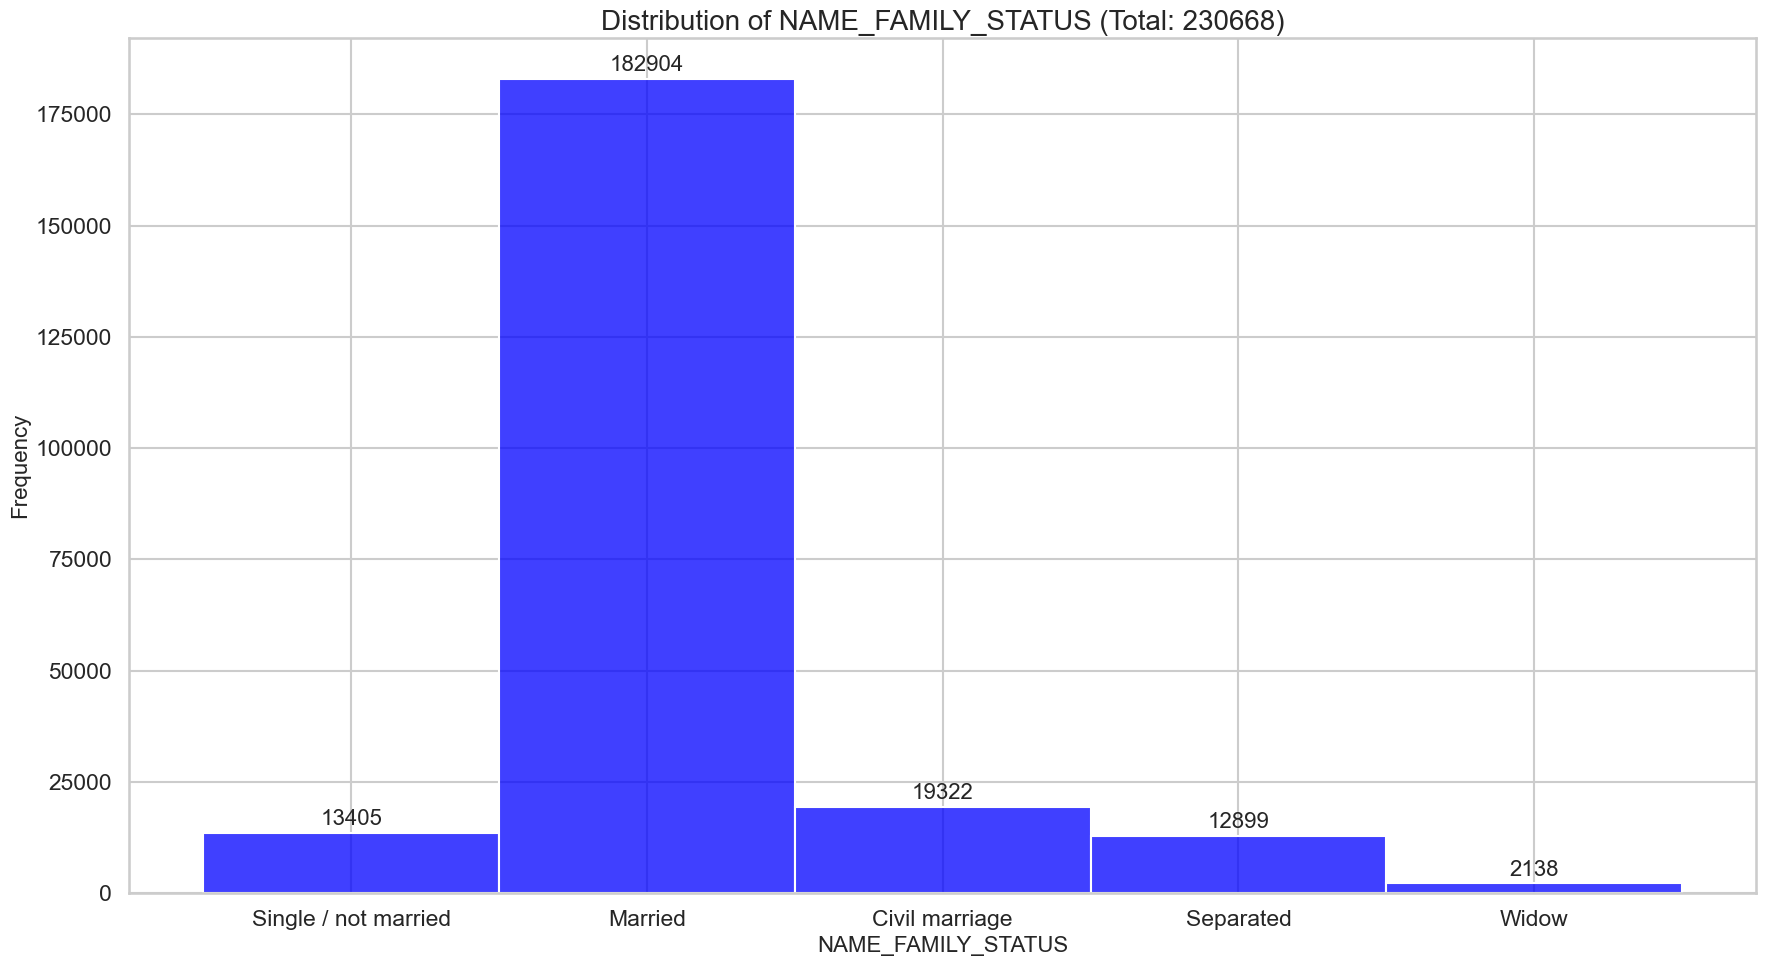

In [35]:
hist(full_df, ['NAME_FAMILY_STATUS'], bins=20)

Most of our customers are married, which will definitely impact some of our linear models.

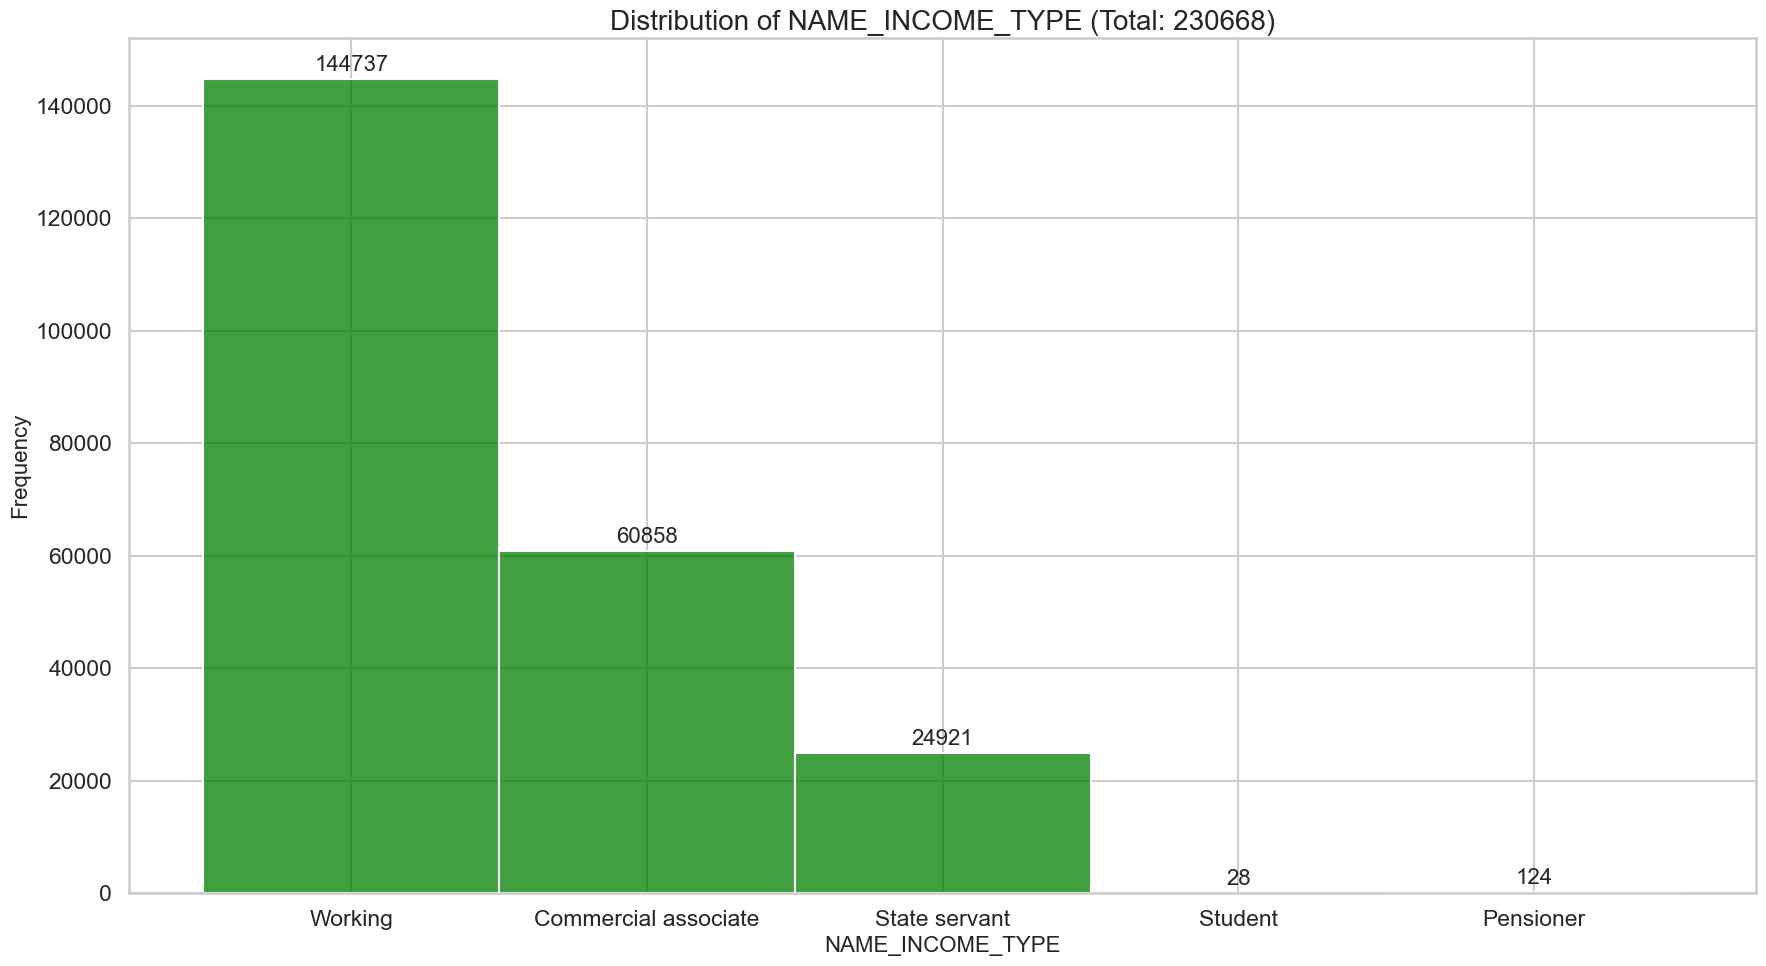

In [36]:
hist(full_df, ['NAME_INCOME_TYPE'], bins=20, color='green')

As for the NAME_INCOME_TYPE 'working', it is the majority class, but we can see how many of the other classes are logically easily mergeable with the majority class since almost everyone has a monetary outcome. We will address this issue during the preprocessing phase.

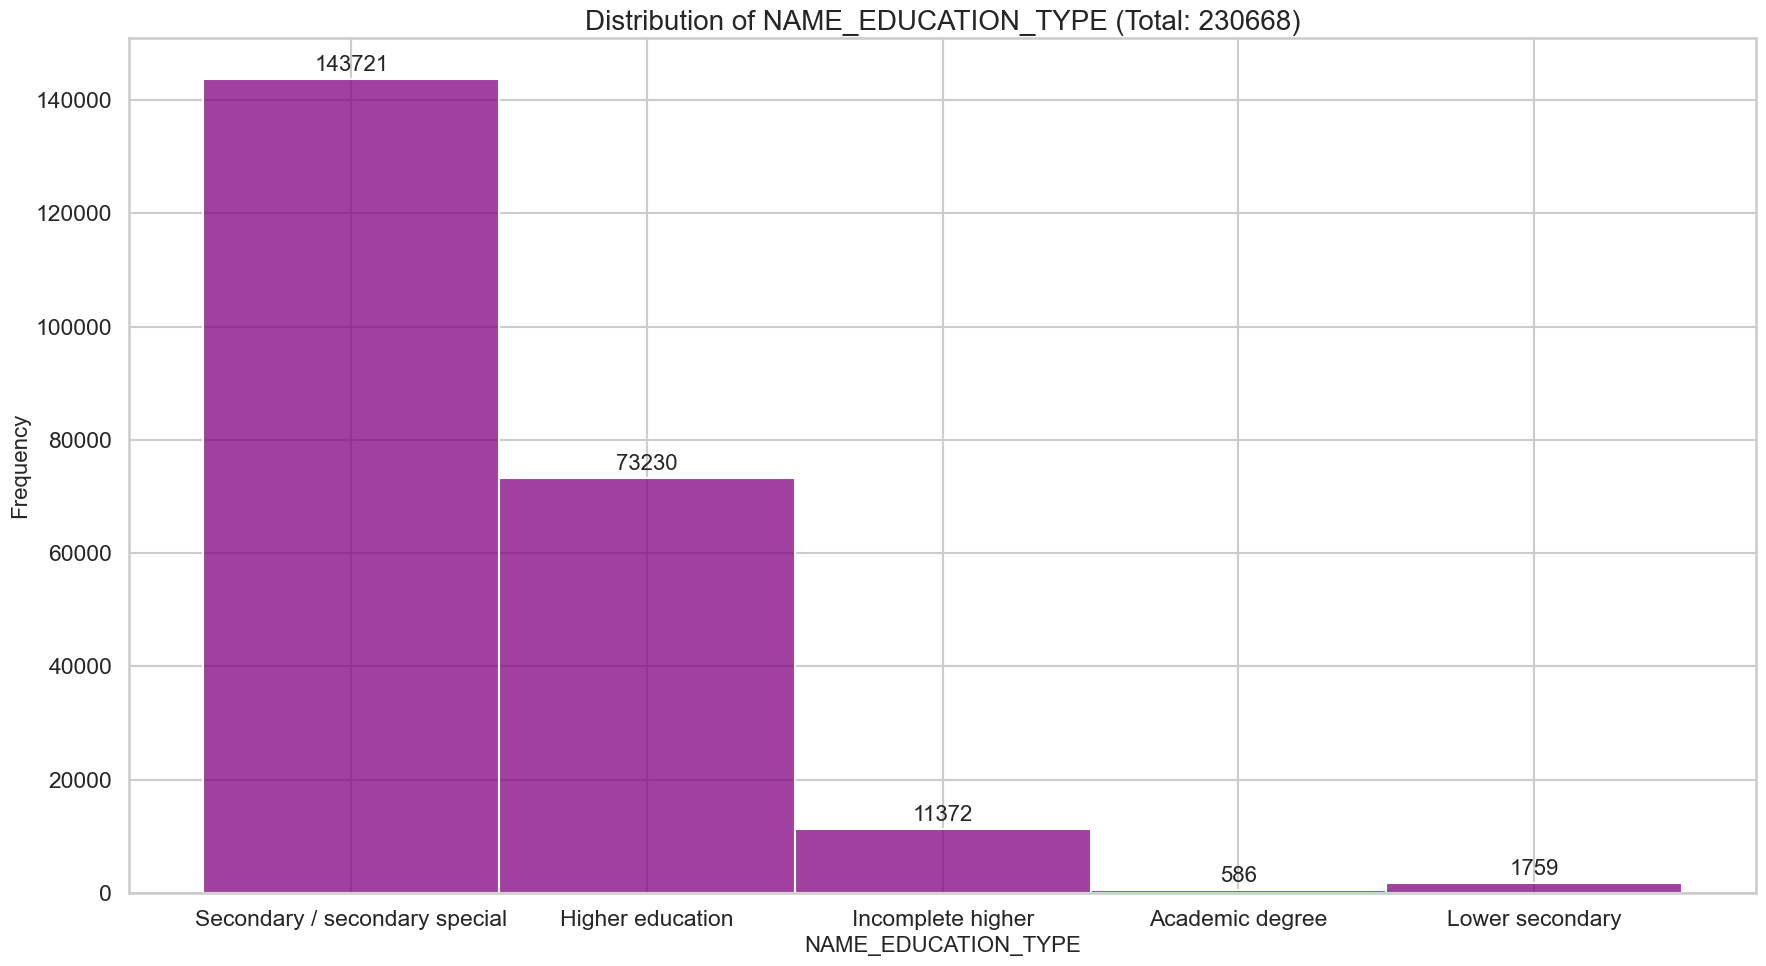

In [37]:
hist(full_df, ['NAME_EDUCATION_TYPE'], bins=9, color= 'purple')

Most of the clients have a high school diploma as their educational qualification, while the highest level (university degree) and the lowest level (elementary education) have very few records representing them.

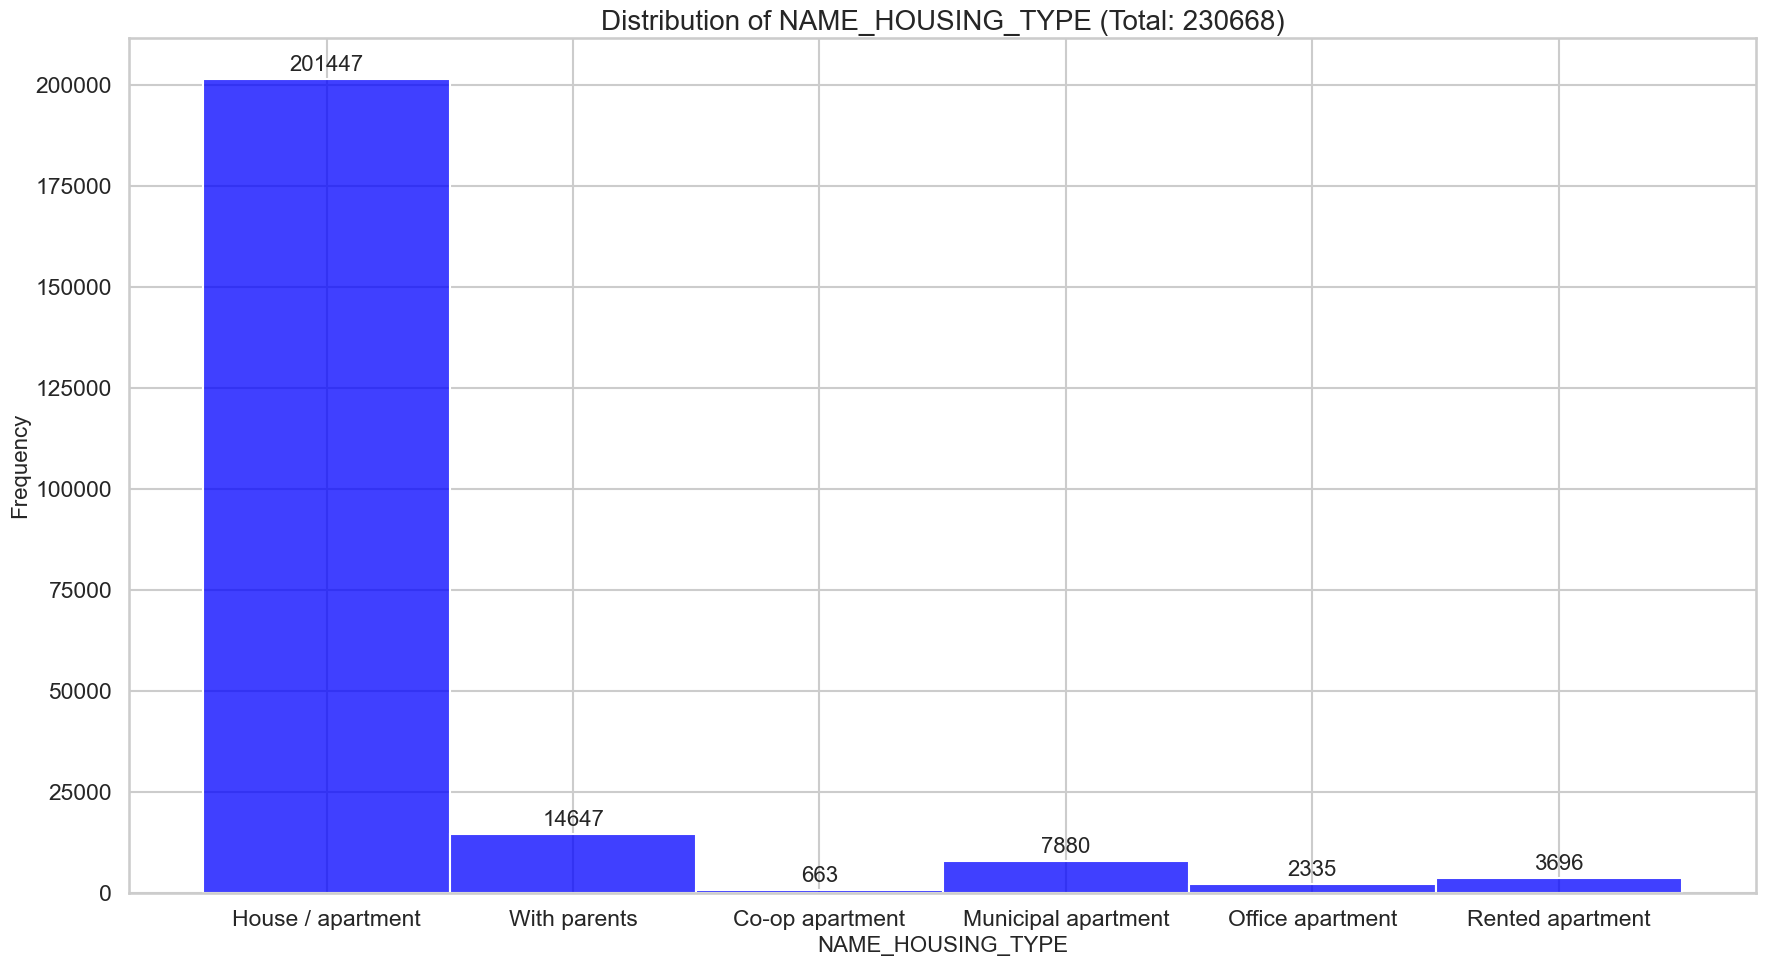

In [38]:
hist(full_df, ['NAME_HOUSING_TYPE'], bins=9, color= 'blue')

We notice right away that the majority of our clients live in owned homes. This could also be important for certain models or for more in-depth customer studies. Owning real estate might suggest financial stability or indicate an ongoing mortgage.

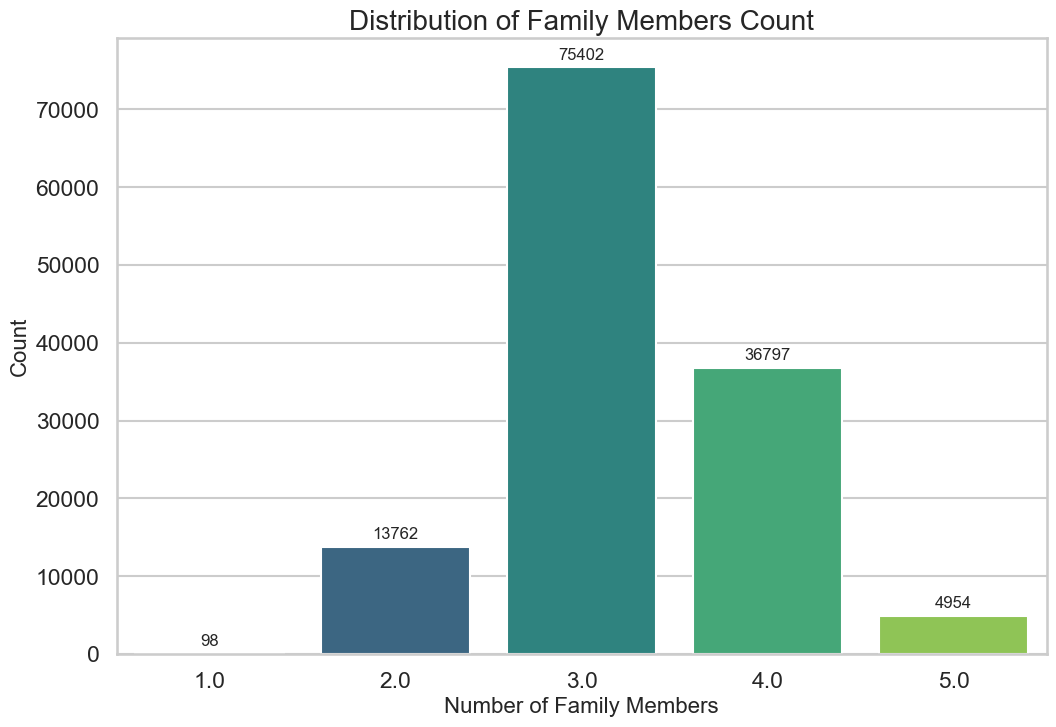

In [39]:


# Set the style and context of the plot for improved aesthetics
sns.set(style="whitegrid")
sns.set_context("talk")

# Create the plot
plt.figure(figsize=(12, 8))  # Adjusting the figure size for better readability
ax = sns.countplot(x='CNT_FAM_MEMBERS', data=ar_df, palette='viridis')  # Use a "viridis" color palette

# Add title and labels with larger font sizes for better readability
ax.set_title('Distribution of Family Members Count', fontsize=20)
ax.set_xlabel('Number of Family Members', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

# Add annotations directly on the bars to show the exact count
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  # No decimal places, only integers
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the annotation
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=12)

# Show the plot
plt.show()


We notice a particular pattern, which is that very few clients live alone. The average is around three members per household.

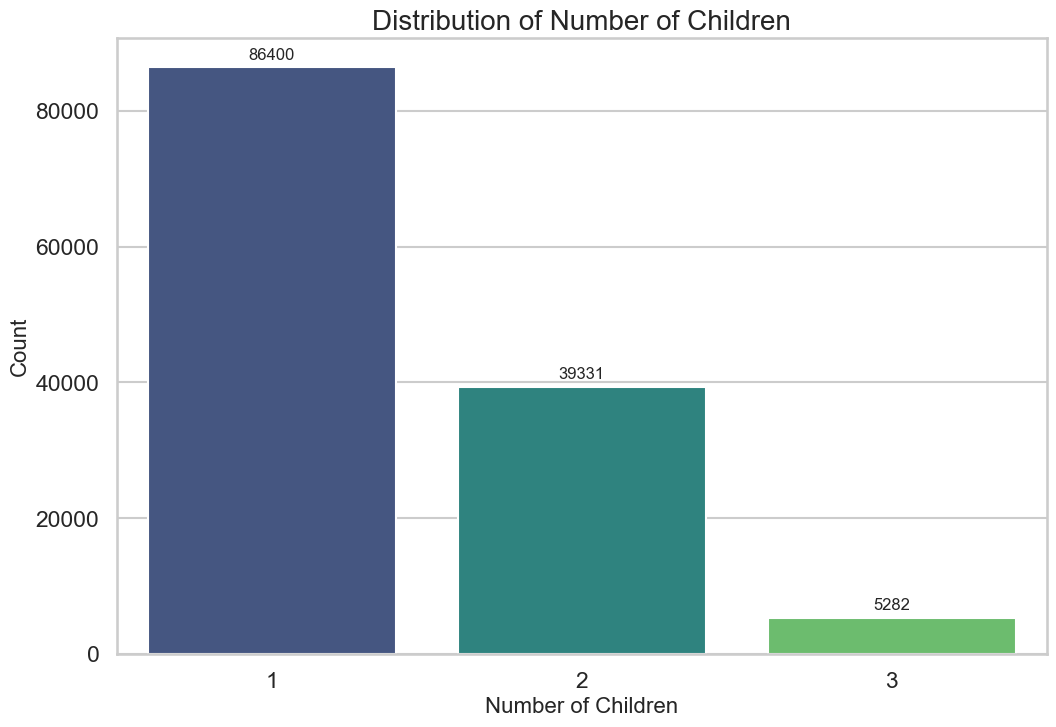

In [40]:
# Set the style and context of the plot for improved aesthetics
sns.set(style="whitegrid")
sns.set_context("talk")

# Create the plot
plt.figure(figsize=(12, 8))  # Adjusting the figure size for better readability
ax = sns.countplot(x='CNT_CHILDREN', data=ar_df, palette='viridis')  # Use a "viridis" color palette

# Add title and labels with larger font sizes for better readability
ax.set_title('Distribution of Number of Children', fontsize=20)
ax.set_xlabel('Number of Children', fontsize=16)
ax.set_ylabel('Count', fontsize=16)

# Add annotations directly on the bars to show the exact count
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  # No decimal places, only integers
                (p.get_x() + p.get_width() / 2., p.get_height()),  # Position for the annotation
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=12)

# Show the plot
plt.show()


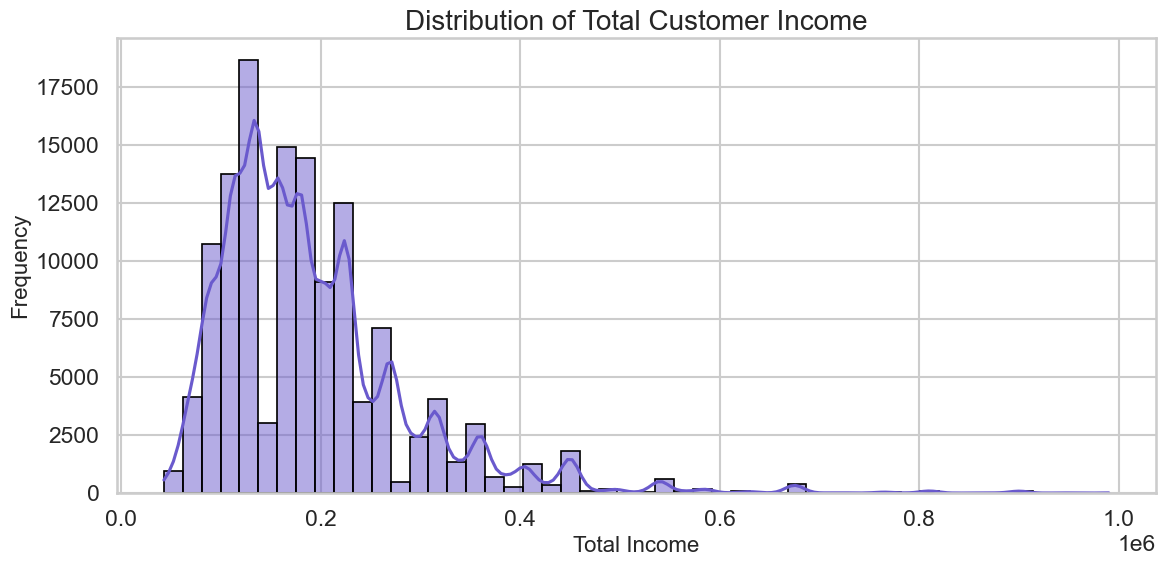

In [41]:
# Set the style and context for Seaborn plots
sns.set(style="whitegrid")
sns.set_context("talk")

plt.figure(figsize=(12, 6))  # Adjusting the figure size

# Create a histogram with KDE using Seaborn
sns.histplot(ar_df['AMT_INCOME_TOTAL'], bins=50, kde=True, color='slateblue', edgecolor='black')

plt.title('Distribution of Total Customer Income', fontsize=20)
plt.xlabel('Total Income', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.show()


From this distribution, we can easily observe that the majority of our clients earn between 15,000 and 20,000 euros per year, a figure that then decreases almost logarithmically with the increase in total income

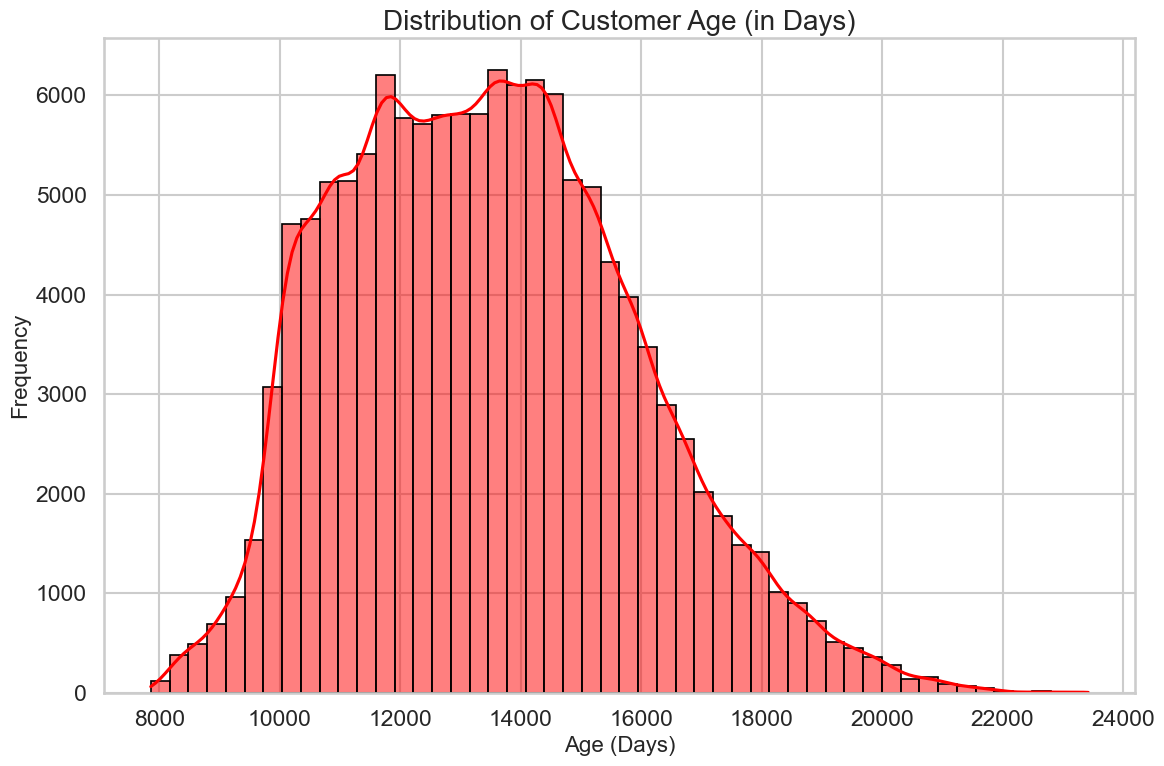

In [42]:

# Set the plot style
sns.set(style="whitegrid")
sns.set_context("talk")

plt.figure(figsize=(12, 8))

# Create a histogram while keeping DAYS_BIRTH in days
# Note that we are flipping the sign of the values to display age as positive
sns.histplot(-ar_df['DAYS_BIRTH'], bins=50, kde=True, color='red', edgecolor='black')

plt.title('Distribution of Customer Age (in Days)', fontsize=20)
plt.xlabel('Age (Days)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.show()


The age, expressed here in days, takes on a Gaussian shape like many human-related data points. We will work on this feature during preprocessing to make it more understandable.

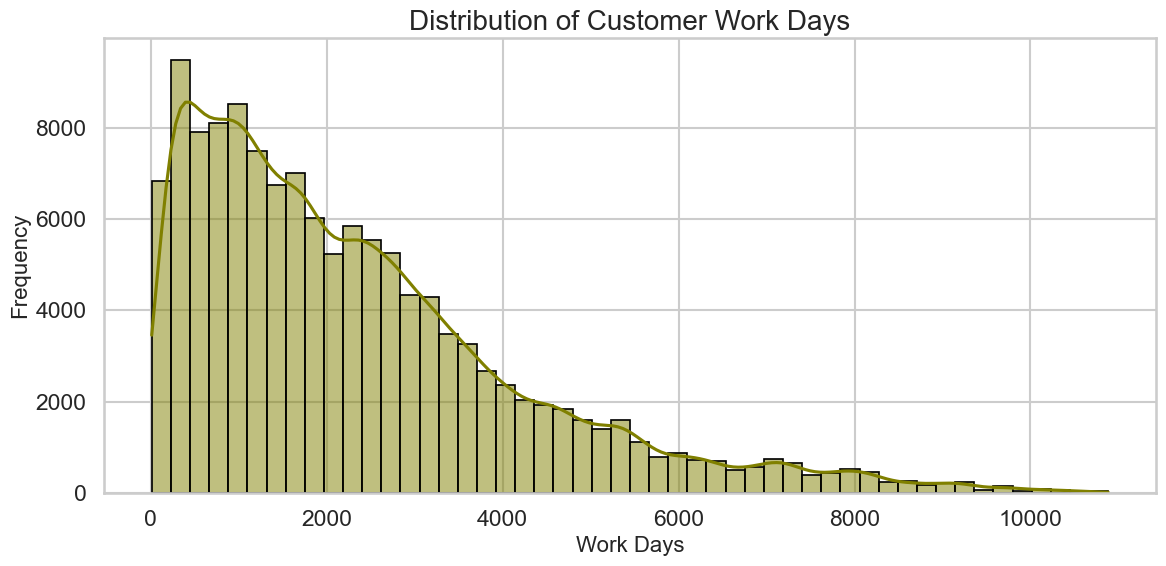

In [43]:
plt.figure(figsize=(12, 6))

# Create a histogram with KDE using Seaborn for the DAYS_EMPLOYED column
# Negative values are assumed to represent days worked; positive values could indicate non-applicable data or errors
sns.histplot(-ar_df['DAYS_EMPLOYED'], bins=50, kde=True, color='olive', edgecolor='black')

plt.title('Distribution of Customer Work Days', fontsize=20)
plt.xlabel('Work Days', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.tight_layout()
plt.show()


The days worked follow a long-tail distribution because short periods of work are much more common than long periods. The longer they go, the rarer they become.

# Preprocessing

For categorical variables, we display unique values.

In [44]:
# Display unique values for the NAME_INCOME_TYPE column
print(f"Unique values in NAME_INCOME_TYPE:\n{full_df['NAME_INCOME_TYPE'].unique()}\n")

# Display unique values for the NAME_EDUCATION_TYPE column
print(f"Unique values in NAME_EDUCATION_TYPE:\n{full_df['NAME_EDUCATION_TYPE'].unique()}\n")

# Display unique values for the NAME_FAMILY_STATUS column
print(f"Unique values in NAME_FAMILY_STATUS:\n{full_df['NAME_FAMILY_STATUS'].unique()}\n")

# Display unique values for the NAME_HOUSING_TYPE column
print(f"Unique values in NAME_HOUSING_TYPE:\n{full_df['NAME_HOUSING_TYPE'].unique()}\n")

Unique values in NAME_INCOME_TYPE:
['Working' 'Commercial associate' 'State servant' 'Student' 'Pensioner']

Unique values in NAME_EDUCATION_TYPE:
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Academic degree' 'Lower secondary']

Unique values in NAME_FAMILY_STATUS:
['Single / not married' 'Married' 'Civil marriage' 'Separated' 'Widow']

Unique values in NAME_HOUSING_TYPE:
['House / apartment' 'With parents' 'Co-op apartment'
 'Municipal apartment' 'Office apartment' 'Rented apartment']



We will do a binning, dividing into 'with income' and 'without income'. Pensioners are included in those with income as they receive a pension and thus have a fixed income. 

In [45]:
# Define a function that will be applied to each row (or value) in the 'NAME_INCOME_TYPE' column
def classify_income(status):
    if status in ['Working', 'Commercial associate', 'State servant', 'Pensioner']:
        return 1  # Has income
    else:
        return 0  # Does not have income

# Use the apply function to create a new column 'HAS_INCOME' based on the 'NAME_INCOME_TYPE'
full_df['HAS_INCOME'] = full_df['NAME_INCOME_TYPE'].apply(classify_income)

Delete column  NAME_INCOME_TYPE column, to avoid multicollinearity.

In [46]:
full_df = full_df.drop(columns=['NAME_INCOME_TYPE'])
full_df.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,HAS_INCOME
0,5008834,F,N,Y,1,112500.0,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,0,0,0,2.0,0,C,1
1,5008834,F,N,Y,1,112500.0,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,0,0,0,2.0,-1,C,1
2,5008834,F,N,Y,1,112500.0,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,0,0,0,2.0,-2,C,1
3,5008834,F,N,Y,1,112500.0,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,0,0,0,2.0,-3,C,1
4,5008834,F,N,Y,1,112500.0,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,0,0,0,2.0,-4,C,1


We binned the feature housing_type, dividing into owned_house (1) and non_owners (0).

In [47]:
# Define a function to bin housing types into categories 'Owned House')' and 'Non owners')
def bin_housing_type(housing_type):
    if housing_type in ['House / apartment', 'Municipal apartment', 'Co-op apartment']:
        return 1
    else:
        return 0
    
# Applying binning
full_df['HOUSING_CATEGORY'] = full_df['NAME_HOUSING_TYPE'].apply(bin_housing_type)
full_df = full_df.drop(columns=['NAME_HOUSING_TYPE'])

Similar operation for marital_status, which will be divided into Married(1) and not Married (0).

In [48]:
# Define a function to classify each marital status as "Married" or "Not Married"
def classify_marital_status(status):
    if status in ['Civil marriage', 'Married']:
        return 1  # Married
    else:
        return 0  # Not Married

# Use the apply function to create a new column 'Marital_Status_Classified'
full_df['MARITAL_STATUS'] = full_df['NAME_FAMILY_STATUS'].apply(classify_marital_status)

# Remove the original column 'NAME_FAMILY_STATUS' to avoid multicollinearity among features.
full_df = full_df.drop(columns=['NAME_FAMILY_STATUS'])

Now we move on to the mapping for the client's sex, with M = 0 and F = 1.

In [49]:
# Define a mapping dictionary to map gender values to numerical values
map_gender = {"M": 0, "F": 1}

# Use the map method to replace gender values in the 'CODE_GENDER' column with numerical values
full_df["CODE_GENDER"] = full_df["CODE_GENDER"].map(map_gender)

Here, too, we proceed with the mapping.

In [50]:
# Define a mapping dictionary for boolean values where "Y" maps to 0 and "N" maps to 1
map_bool = {"Y" : 0, "N" : 1}

# Use the map method to replace values.
full_df["FLAG_OWN_CAR"] = full_df["FLAG_OWN_CAR"].map(map_bool)
full_df["FLAG_OWN_REALTY"] = full_df["FLAG_OWN_REALTY"].map(map_bool)

In this case, we do not have two values, but five. Since variables can be ordered in a logical sense, we apply an increasing scale from 0 to 4 according to their value.

In [51]:
# Define a mapping dictionary for education levels
map_educ = {'Lower secondary': 0,
           'Secondary / secondary special': 1,
           'Incomplete higher': 2,
           'Higher education': 3,
           'Academic degree': 4}

# Use the map method along with a lambda function to replace values in the 'NAME_EDUCATION_TYPE' column
# The lambda function takes each value x from the 'NAME_EDUCATION_TYPE' column and maps it to the corresponding value in map_educ
full_df['NAME_EDUCATION_TYPE'] = full_df['NAME_EDUCATION_TYPE'].map(lambda x: map_educ[x])

Let us turn the variable from days into years, to make it more understandable. To do this, we will divide the years by 365.25, so as to take leap year into account, and taking care to keep the minus sign.

In [52]:
full_df['YEARS_BIRTH'] = full_df['DAYS_BIRTH'] / - 365.25

Having done so, we delete the now useless DAYS_BIRTH column.

In [53]:
full_df.drop('DAYS_BIRTH', axis=1, inplace=True)

Convert days of employment to years in the YEARS_EMPLOYED column

In [54]:
# Divide employment days by 365.25 to account for leap years in the calculation
full_df['YEARS_EMPLOYED'] = full_df['DAYS_EMPLOYED'] / - 365.25

# Drop the original DAYS_EMPLOYED column from the DataFrame
# It's no longer needed having transformed its data into the YEARS_EMPLOYED column
full_df = full_df.drop('DAYS_EMPLOYED', axis=1)

Mapping for the status variable, so that it can then be used to create TARGET. C and X become 6 and 7, after which the values 2, 3, 4 and 5 are assigned the binary value 1, the rest 0.

In [55]:
# First, map the values "C" and "X" to integers 6 and 7 respectively
map_status = {"C": 6, "X": 7}
full_df["STATUS"] = full_df["STATUS"].map(map_status).fillna(full_df["STATUS"])

# Now, convert the 'STATUS' column to integers to ensure all values are numeric
full_df["STATUS"] = full_df["STATUS"].astype(int)

# Finally, use a lambda function with apply to set 'TARGET' to 1 for values 3, 4, and 5, otherwise set it to 0
full_df['TARGET'] = full_df['STATUS'].apply(lambda x: 1 if x in [2, 3, 4, 5] else 0)

In [56]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230668 entries, 0 to 230667
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   230668 non-null  int64  
 1   CODE_GENDER          230668 non-null  int64  
 2   FLAG_OWN_CAR         230668 non-null  int64  
 3   FLAG_OWN_REALTY      230668 non-null  int64  
 4   CNT_CHILDREN         230668 non-null  int64  
 5   AMT_INCOME_TOTAL     230668 non-null  float64
 6   NAME_EDUCATION_TYPE  230668 non-null  int64  
 7   FLAG_WORK_PHONE      230668 non-null  int64  
 8   FLAG_PHONE           230668 non-null  int64  
 9   FLAG_EMAIL           230668 non-null  int64  
 10  CNT_FAM_MEMBERS      230668 non-null  float64
 11  MONTHS_BALANCE       230668 non-null  int64  
 12  STATUS               230668 non-null  int32  
 13  HAS_INCOME           230668 non-null  int64  
 14  HOUSING_CATEGORY     230668 non-null  int64  
 15  MARITAL_STATUS   

In [57]:
# First, we calculate the desired aggregations
aggregated_data = full_df.groupby('ID').agg({
    'TARGET': 'mean',  # The average TARGET for each ID
    'AMT_INCOME_TOTAL': 'max',  # The maximum AMT_INCOME_TOTAL for each ID
    'YEARS_BIRTH': 'first'  # The first value of YEARS_BIRTH for each ID (assuming invariance)
}).reset_index()

# Since the other columns must remain unchanged and assuming there is a representative row for each ID in the original DataFrame
# To simplify, you can select one row per ID from the original DataFrame (here we take the first one)
# This assumes that the values in the other columns are consistent for each ID, or that you are choosing the correct course of action in case of discrepancies

# Drop of columns defined by aggregation to avoid conflicts after merge
cleaned_full_df = full_df.drop(columns=['TARGET', 'AMT_INCOME_TOTAL', 'YEARS_BIRTH']).drop_duplicates(subset='ID', keep='first')

# We now merge with the aggregated data
final_df = pd.merge(cleaned_full_df, aggregated_data, on='ID', how='left')

# This final_df will have the columns ‘TARGET’, ‘AMT_INCOME_TOTAL’, and ‘YEARS_BIRTH’ aggregated as desired,
# while all other columns will remain unchanged with representative values (based on the first available record for each ID).
final_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,NAME_EDUCATION_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS,HAS_INCOME,HOUSING_CATEGORY,MARITAL_STATUS,YEARS_EMPLOYED,TARGET,AMT_INCOME_TOTAL,YEARS_BIRTH
0,5008834,1,1,0,1,1,0,0,0,2.0,0,6,1,1,0,4.435318,0.0,112500.0,30.028747
1,5008835,1,1,0,1,1,0,0,0,2.0,-28,7,1,1,0,4.435318,0.0,112500.0,30.028747
2,5008836,0,0,0,3,1,0,0,0,5.0,-8,6,1,1,1,3.184120,0.0,270000.0,34.740589
3,5008837,0,0,0,3,1,0,0,0,5.0,-2,6,1,1,1,3.184120,0.0,270000.0,34.740589
4,5008838,0,1,0,1,3,0,0,0,3.0,-9,7,1,1,1,5.519507,0.0,405000.0,32.421629


In [58]:
unique_ids_count = final_df['ID'].nunique()
total_rows = final_df.shape[0]

if unique_ids_count == total_rows:
    print("All IDs are unique.")
else:
    print("There are duplicate IDs.")

All IDs are unique.


In [59]:
# Rounding of TARGET values
final_df['TARGET'] = final_df['TARGET'].apply(lambda x: 1 if x >= 0.5 else 0)

# Now check the unique values after rounding
unique_target_values_after_rounding = final_df['TARGET'].unique()
print("Unique values in TARGET after rounding:", unique_target_values_after_rounding)


Unique values in TARGET after rounding: [0 1]


In [60]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10909 entries, 0 to 10908
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10909 non-null  int64  
 1   CODE_GENDER          10909 non-null  int64  
 2   FLAG_OWN_CAR         10909 non-null  int64  
 3   FLAG_OWN_REALTY      10909 non-null  int64  
 4   CNT_CHILDREN         10909 non-null  int64  
 5   NAME_EDUCATION_TYPE  10909 non-null  int64  
 6   FLAG_WORK_PHONE      10909 non-null  int64  
 7   FLAG_PHONE           10909 non-null  int64  
 8   FLAG_EMAIL           10909 non-null  int64  
 9   CNT_FAM_MEMBERS      10909 non-null  float64
 10  MONTHS_BALANCE       10909 non-null  int64  
 11  STATUS               10909 non-null  int32  
 12  HAS_INCOME           10909 non-null  int64  
 13  HOUSING_CATEGORY     10909 non-null  int64  
 14  MARITAL_STATUS       10909 non-null  int64  
 15  YEARS_EMPLOYED       10909 non-null 

We delete the STATUS column, now represented by TARGET, so as to avoid multicollinearity.

In [61]:
final_df = final_df.drop(["STATUS", "MONTHS_BALANCE"], axis=1)

Let us now see how many 0's and 1's are present in TARGET, remembering that 0's are the values that do not present problems in payments, as opposed to 1's.

In [62]:
final_df['TARGET'].value_counts()

TARGET
0    10896
1       13
Name: count, dtype: int64

In [63]:
final_df['ID'].nunique()

10909

There is a clear imbalance in our TARGET variable, which we will have to address later with under or oversampling.

# Second EDA and Features selection

In [64]:
var_quant = ['AMT_INCOME_TOTAL', 'YEARS_BIRTH', 'YEARS_EMPLOYED', 'CNT_FAM_MEMBERS']
var_qual = ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY',
            'HAS_INCOME', 'NAME_EDUCATION_TYPE','MARITAL_STATUS',
            'HOUSING_CATEGORY', 'FLAG_WORK_PHONE', 'FLAG_PHONE','FLAG_EMAIL']

for var in var_qual:
  print(pd.crosstab(full_df[var], final_df.TARGET, normalize='index'))
  print('\n'+' - '*10+'\n')


TARGET              0         1
CODE_GENDER                    
0            0.999266  0.000734
1            0.998535  0.001465

 -  -  -  -  -  -  -  -  -  - 

TARGET               0         1
FLAG_OWN_CAR                    
0             0.998419  0.001581
1             0.999233  0.000767

 -  -  -  -  -  -  -  -  -  - 

TARGET                  0         1
FLAG_OWN_REALTY                    
0                0.998791  0.001209
1                0.998863  0.001137

 -  -  -  -  -  -  -  -  -  - 

TARGET             0         1
HAS_INCOME                    
1           0.998808  0.001192

 -  -  -  -  -  -  -  -  -  - 

TARGET                      0         1
NAME_EDUCATION_TYPE                    
1                    0.999085  0.000915
2                    1.000000  0.000000
3                    0.997975  0.002025
4                    1.000000  0.000000

 -  -  -  -  -  -  -  -  -  - 

TARGET                 0         1
MARITAL_STATUS                    
0               1.000000  0.

1. **Gender** (`CODE_GENDER`): 
   - The difference between genders regarding the class 1 is minimal, indicating gender has little impact on the target variable.

2. **Car Ownership** (`FLAG_OWN_CAR`): 
   - Here too, the difference between owning a car and not owning one is minimal in terms of impacting the class 1.

3. **Real Estate Ownership** (`FLAG_OWN_REALTY`): 
   - Similar to the previous categories, owning real estate has a minimal impact on the distribution of the target variable.

4. **Income** (`Has_Income`): 
   - Those without income have zero probability of belonging to class 1, suggesting this feature is highly influential and potentially pivotal.

5. **Education Level** (`NAME_EDUCATION_TYPE`): 
   - Here, a wider variation is observed across different education categories, suggesting that the level of education might have an influence on the target variable, especially noting category "4" has a zero probability for class 1.

6. **Marital Status** (`MARITAL_STATUS`): 
   - Small variability, suggesting limited impact on the target.

7. **Housing Category** (`HOUSING_CATEGORY`): 
   - Minor differences between categories suggest limited impact on TARGET.

8. **Work Phone** (`FLAG_WORK_PHONE`), **Personal Phone** (`FLAG_PHONE`), and **Email** (`FLAG_EMAIL`): 
   - Variations in distributions of these features suggest a relatively limited impact, with slight variations for having a work phone.

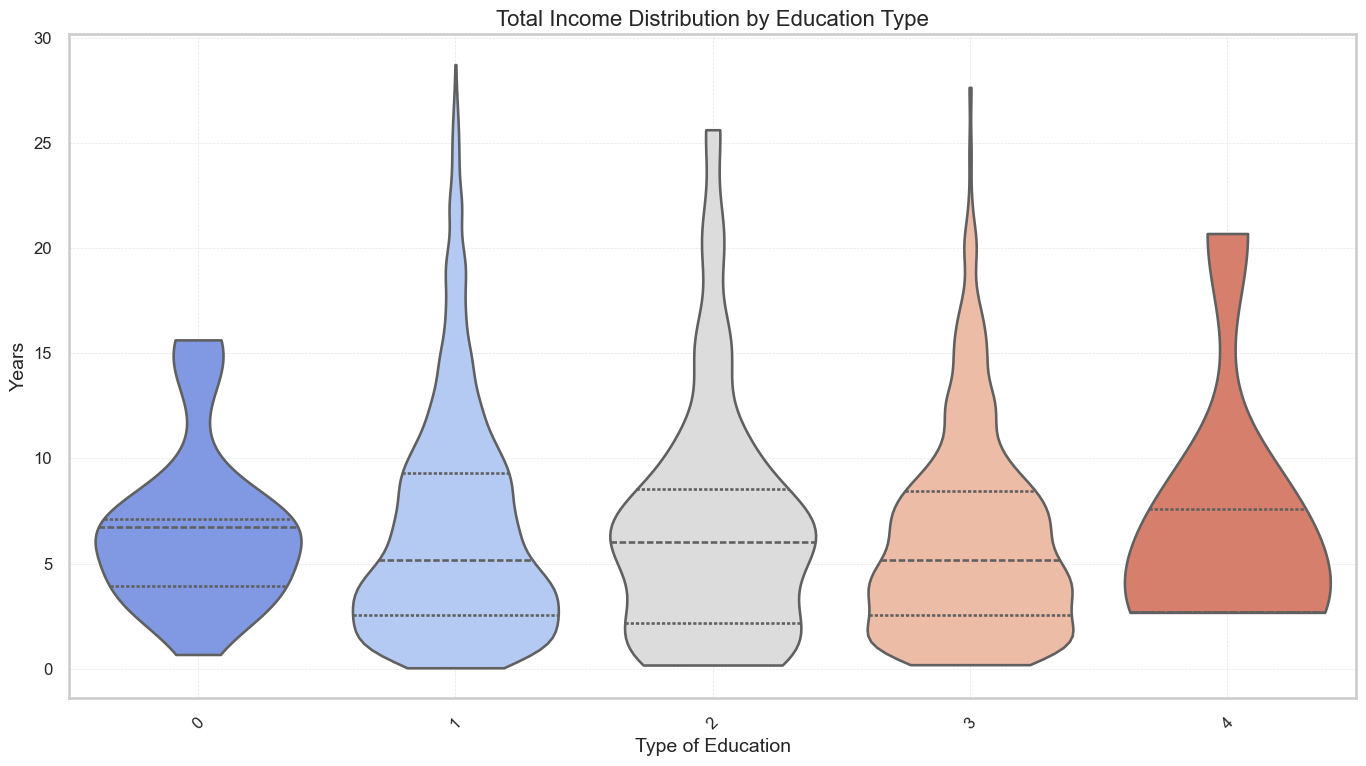

In [65]:
plt.figure(figsize=(14, 8))  # Larger size for better readability
sns.violinplot(x='NAME_EDUCATION_TYPE', y='YEARS_EMPLOYED', data=final_df,
               palette="coolwarm", inner="quartile", cut=0)  # Improved palette and style
plt.title("Total Income Distribution by Education Type", fontsize=16)  # Translated title
plt.xticks(rotation=45, fontsize=12)  # More readable x-axis labels
plt.yticks(fontsize=12)  # More readable y-axis labels
plt.xlabel('Type of Education', fontsize=14)  # Translated x-axis label
plt.ylabel('Years', fontsize=14)  # Translated y-axis label
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)  # Light grid for better readability
plt.tight_layout()  # Optimizes the layout of subplots

plt.show()

This violin graph represents the total years as a worker according to the client's level of education, previously coded in the preprocessing phase according to the following criteria:  

'Lower secondary': 0,  
'Secondary / secondary special': 1,  
'Incomplete higher': 2,  
'Higher education': 3,  
'Academic degree': 4.  

Clients with lower secondary education are concentrated around five years, with outliers touching 15 years. for other types of education the interquartile range is much wider, with positive outliers reaching beyond 25 years of employment. Special mention to clients with an academic degree, who turn out to have a lower range of years of employment than the others. This is probably due to the fact that they have spent more years in education.

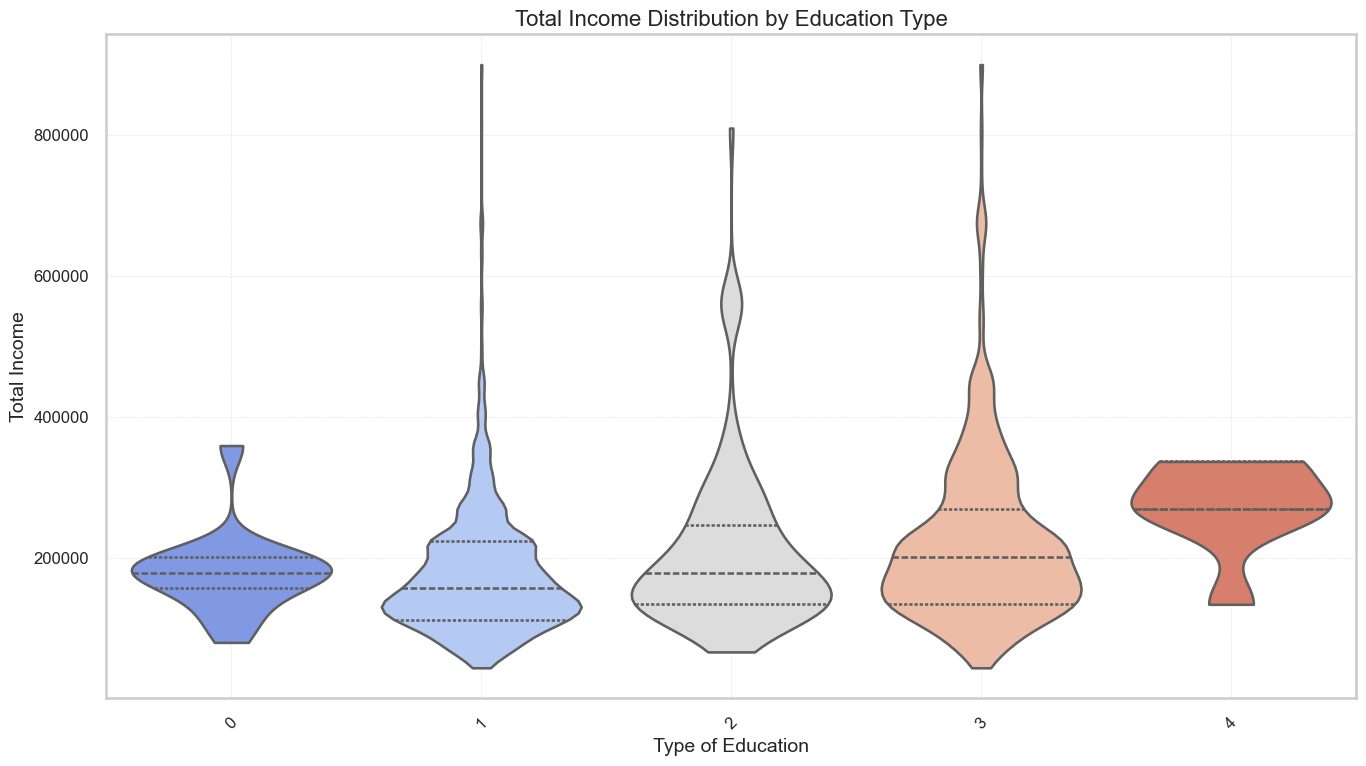

In [66]:
plt.figure(figsize=(14, 8))  # Larger size for better readability
sns.violinplot(x='NAME_EDUCATION_TYPE', y='AMT_INCOME_TOTAL', data=final_df,
               palette="coolwarm", inner="quartile", cut=0)  # Improved palette and style
plt.title("Total Income Distribution by Education Type", fontsize=16)  # Translated title
plt.xticks(rotation=45, fontsize=12)  # More readable x-axis labels
plt.yticks(fontsize=12)  # More readable y-axis labels
plt.xlabel('Type of Education', fontsize=14)  # Translated x-axis label
plt.ylabel('Total Income', fontsize=14)  # Translated y-axis label
plt.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.5)  # Light grid for better readability
plt.tight_layout()  # Optimizes the layout of subplots

plt.show()

In this graph we can see how total income varies according to the level of education of the client.

It is immediately clear that levels 1, 2 and 3 have a larger box compared to the lowest level of education and are certainly more prone to variability.  This case would require a more in-depth study, but one of the causes could be manual work with a higher number of hours for clients belonging to class 0.  Already at level 3 there is an increase in the number and range of cases, with a much wider interquartile range.

Very peculiar is the violin plot for level 4, which I recall indicates an academic degree; in this case the median is much higher, indicating a higher average salary. There are also negative outliers below 20,000, which could represent graduates just starting out.

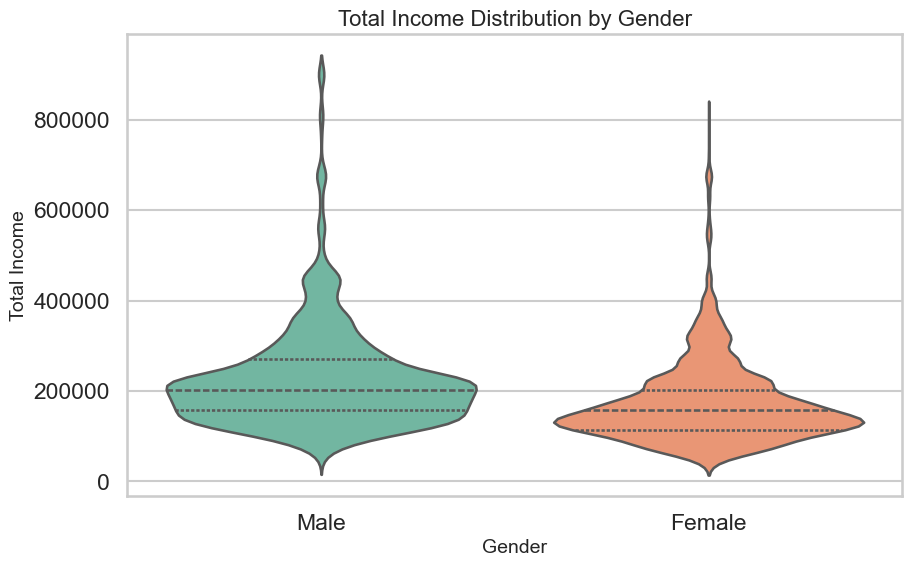

In [67]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='CODE_GENDER', y='AMT_INCOME_TOTAL', data=final_df, palette='Set2', inner='quartile')
plt.title("Total Income Distribution by Gender", fontsize=16) 
plt.xlabel('Gender', fontsize=14) 
plt.ylabel('Total Income', fontsize=14) 
plt.xticks([0, 1], ['Male', 'Female']) 
plt.show()

This graph shows total income divided by the gender of the client.

The graphs have similar shapes, with a wide rose near the interquartile range, but it is clear from the start that men earn more on average than women, with a visible gap. 

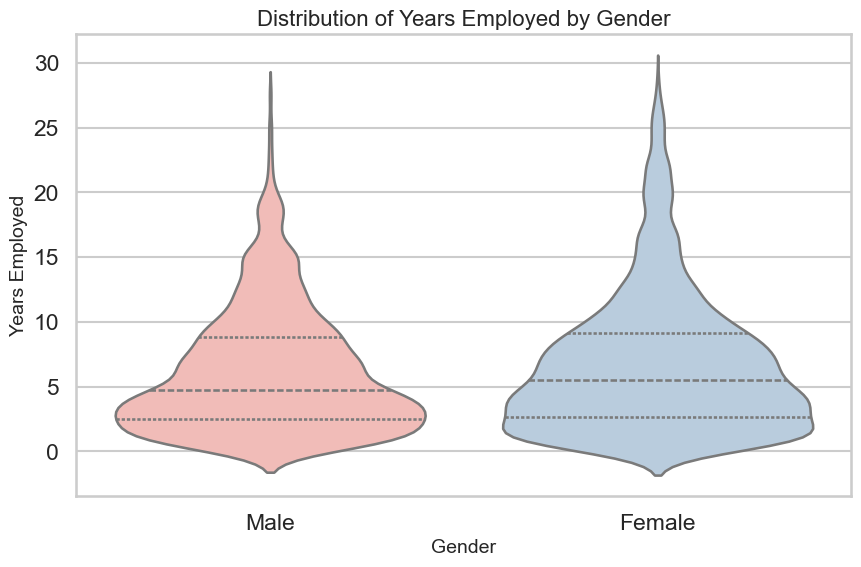

In [68]:

plt.figure(figsize=(10, 6))
sns.violinplot(x='CODE_GENDER', y='YEARS_EMPLOYED', data=final_df, palette='Pastel1', inner='quartile')
plt.title("Distribution of Years Employed by Gender", fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Years Employed', fontsize=14)
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

In this last graph we represent the distribution of years as workers by gender.

The distributions are very similar to each other, comparable, so we do not notice much difference. The only note is the presence of more positive outliers for female clients.

Let us focus on studying our features, starting with the elimination of 'ID', and a study of the other features through a heatmap.

In [69]:
final_df = final_df.drop({"ID"},axis=1)

In [70]:
def create_heatmap(dataset):
    plt.figure(figsize=(16, 10)) 
    sns.heatmap(dataset.corr(), annot=True, annot_kws={"size": 8}, cmap='coolwarm')
    plt.show()

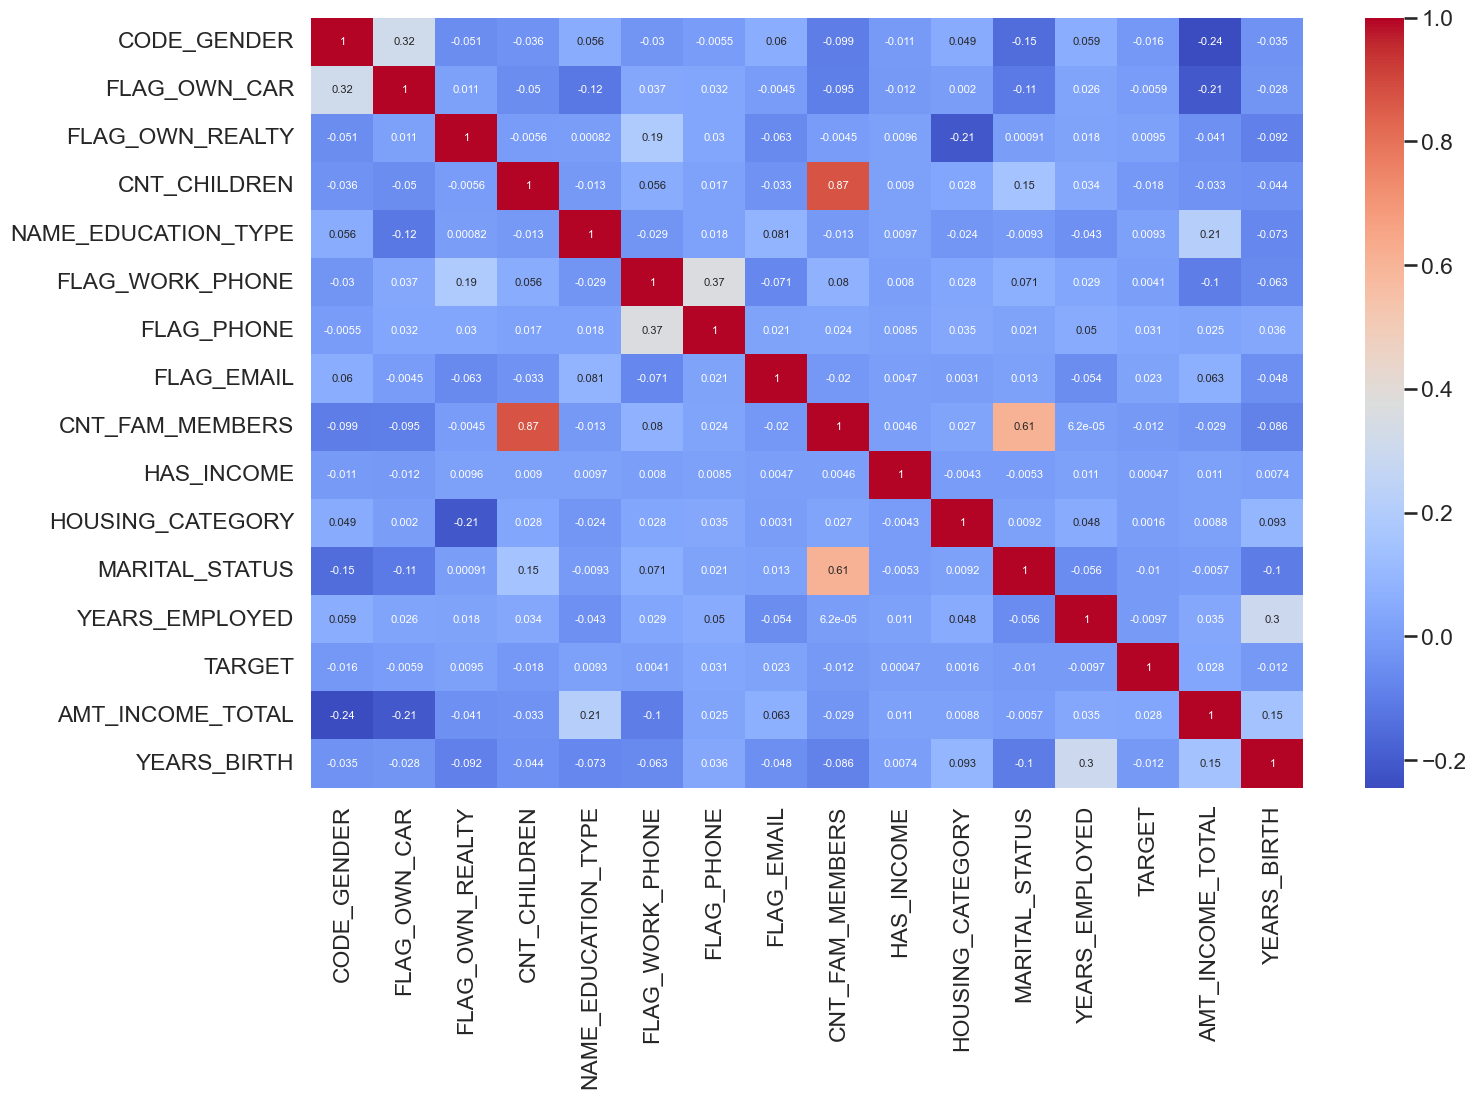

In [71]:
create_heatmap(final_df)

CNT_CHILDREN and CNT_FAM_MEMBERS show a very high correlation (around 0.89). This is intuitive as the number of household members includes children.

In [72]:
# For VIF analysis, it's necessary to add a constant to the DataFrame.
# This is because VIF analysis assumes the presence of an intercept in the regression model.
df_with_constant = add_constant(final_df[['CNT_CHILDREN', 'CNT_FAM_MEMBERS']])

# Initialize a DataFrame to store the VIF values and the names of the features.
vif_data = pd.DataFrame()

# Store the names of the features in the 'Feature' column of the vif_data DataFrame.
vif_data["Feature"] = df_with_constant.columns

# Calculate the VIF for each variable in the DataFrame with the constant added.
# The variance_inflation_factor function requires two arguments: 
# 1. The entire dataset as a NumPy array (here obtained via df_with_constant.values).
# 2. The index of the variable for which you are calculating the VIF.
# The variance_inflation_factor is calculated for each feature and stored in the 'VIF' column.
vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i) for i in range(df_with_constant.shape[1])]

print(vif_data)

           Feature        VIF
0            const  33.660431
1     CNT_CHILDREN   4.202305
2  CNT_FAM_MEMBERS   4.202305


Since the multicollinearity is close to the threshold value of 5, I decide to delete the CNT_CHILDREN feature and keep CNT_FAM_MEMBERS as it gives a better overview of the household.

In [73]:
# Dropping the 'CNT_CHILDREN' column from the DataFrame
final_df = final_df.drop('CNT_CHILDREN', axis=1)

# Models

We separate the dataset into a set of independent variables ( X ) and a dependent one (Y), namely the target. 

In [74]:
X = final_df.drop("TARGET", axis=1)
y = final_df["TARGET"]

We apply a seed and a test size of 30 percent of the total, splitting into train and test.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)

Many of these models will be built with a pipeline consisting of a SMOTE due to the unbalance of the target class, a standardisation that will be applied to our training data, and finally the model with its specifications and hyperparameters of the case.

- **Logistic Regression**

The first model we train is a logistic regression, which is used for binary classification problems. It applies a probability of belonging to one of the target classes via the sigmoid function.

In [76]:
'''Logistic Regression'''

# Create and train the pipeline
pipeline_lr = IVPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_SEED)),    # Apply SMOTE to handle imbalanced dataset
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=500, penalty="l2", solver="saga", class_weight="balanced"))
])
pipeline_lr.fit(X_train, y_train)   #Train the pipeline with the training data

# Prediction and evaluation on the training set
y_train_pred = pipeline_lr.predict(X_train)
y_train_prob = pipeline_lr.predict_proba(X_train)[:, 1]

# Prediction and evaluation on the test set
y_test_pred = pipeline_lr.predict(X_test)
y_test_prob = pipeline_lr.predict_proba(X_test)[:, 1]

# Calculation of metrics for the training set
classification_report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
auc_roc_train = roc_auc_score(y_train, y_train_prob)

print("\nTraining Set Metrics:")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train)
print("\nAUC-ROC Training Set:", auc_roc_train)

# Calculation of metrics for the test set
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_prob)

print("\nTest Set Metrics:")
print("Classification Report Test Set:")
print(pd.DataFrame(classification_report_test).transpose())
print("\nConfusion Matrix Test Set:\n", confusion_matrix_test)
print("\nAUC-ROC Test Set:", auc_roc_test)


Training Set Metrics:
Classification Report Training Set:
              precision    recall  f1-score      support
0              0.999018  0.800393  0.888743  7625.000000
1              0.003274  0.454545  0.006502    11.000000
accuracy       0.799895  0.799895  0.799895     0.799895
macro avg      0.501146  0.627469  0.447623  7636.000000
weighted avg   0.997583  0.799895  0.887472  7636.000000

Confusion Matrix Training Set:
 [[6103 1522]
 [   6    5]]

AUC-ROC Training Set: 0.716548435171386

Test Set Metrics:
Classification Report Test Set:
              precision    recall  f1-score      support
0              0.999620  0.805258  0.891974  3271.000000
1              0.001567  0.500000  0.003125     2.000000
accuracy       0.805072  0.805072  0.805072     0.805072
macro avg      0.500594  0.652629  0.447550  3273.000000
weighted avg   0.999011  0.805072  0.891431  3273.000000

Confusion Matrix Test Set:
 [[2634  637]
 [   1    1]]

AUC-ROC Test Set: 0.7900489147049832


**Training Set:**

- Precision for the non-default class (0) is very high at 99.74%, suggesting that almost all predictions of class 0 are correct. However, for the default class (1), the precision drops drastically to 0.62%, indicating a very high number of false positives.

- Recall shows a contrasting picture, with only 65.68% for class 0, but 56.60% for class 1. This means the model is relatively more capable of identifying the majority of the actual defaults but fails to capture a significant portion of the non-defaults.

- F1-Score, which combines precision and recall, naturally suffers for both classes but significantly more for class 1 due to its extremely low precision.

- The AUC-ROC score indicates a fair ability of the model to distinguish between default and non-default classes, considering scores range from 0.5 (no discriminatory power) to 1 (perfect).

- The Confusion Matrix reveals the model is heavily biased towards predicting non-defaults, with a high number of false positives (55,198 out of 105,656 actual non-defaults are incorrectly predicted).

**Test Set (Validation):**

- Performance metrics on the test set closely mirror the training set trends, supporting the idea that the model's performance is consistent across unseen data.

- Precision and Recall metrics again highlight the challenge of correctly predicting the minority class with a significant number of instances misclassified.

- The AUC-ROC score on the test set is 0.64, slightly lower than the training set but still indicating fair discriminative power.

The imbalance in the dataset is likely to affect the performance of the model, causing it to over-predict the majority class. Let us now move on to the feature importances.

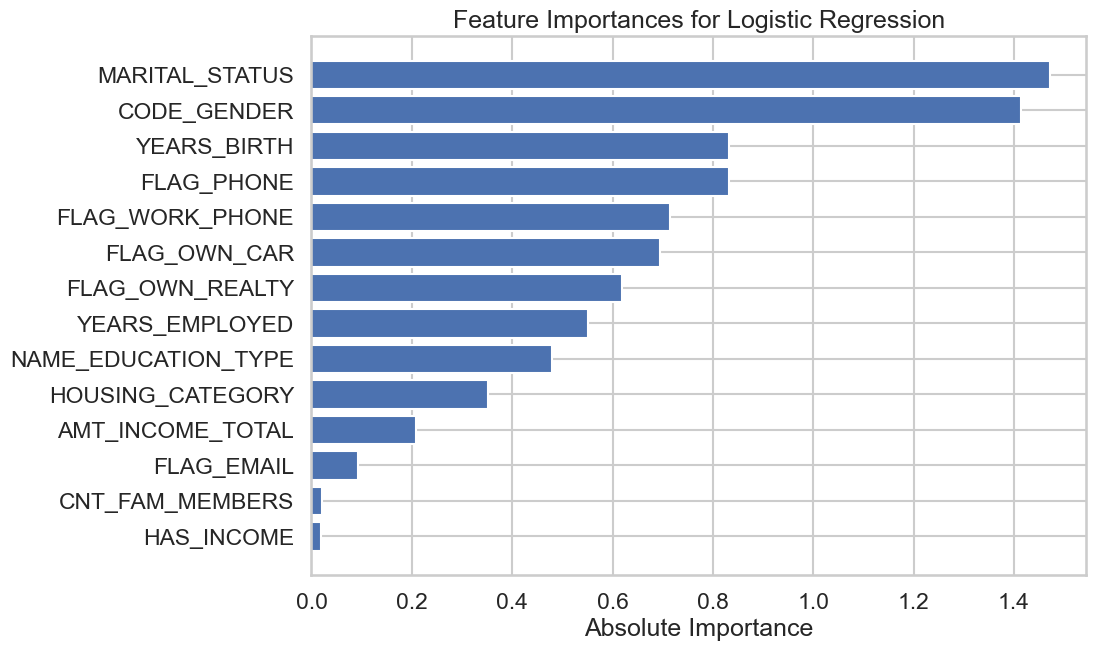

In [77]:
model_lr = pipeline_lr.named_steps['model']  # Access the logistic regression model from the pipeline
features = X_train.columns  # Get the feature names from the training dataframe

# Use the model's coefficients to interpret feature importance
# The coefficients are accessible via `.coef_`, and since `coef_` returns an array within an array for binary models, we use [0] to access the values.
importances = model_lr.coef_[0]  # Assuming a binary outcome for y
indices = np.argsort(np.abs(importances))  # Sort the features by absolute importance

plt.figure(figsize=(10, 7))  # Set the figure size for the plot
plt.title('Feature Importances for Logistic Regression')  # Give the plot a title
plt.barh(range(len(indices)), np.abs(importances[indices]), color='b', align='center')  # Create a horizontal bar plot showing feature importances
plt.yticks(range(len(indices)), [features[i] for i in indices])  # Label the y-axis with feature names
plt.xlabel('Absolute Importance')  # Label the x-axis
plt.show()  # Display the plot

The most important features seem to be FLAG_PHONE, CODE_GENDER and MARITAL_STATUS.

A very strange result, which could be due to the majority class and its distribution for these particular features. We will not go any further as the model is not suitable for our project.

---

---

- **XGB Classifier**

XGBClassifier is an implementation of the Gradient Boosting algorithm, which automatically imputes missing values during training. It also includes L1 and L2 regularisation.

In [78]:
'''XGB Classifier'''

# Pipeline creation and training
pipeline_xgb = IVPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, subsample=0.5, colsample_bytree=0.5, eval_metric="logloss", use_label_encoder=False, random_state=RANDOM_SEED, stratify= y, class_weight="balanced"))
])
pipeline_xgb.fit(X_train, y_train)

# Prediction and evaluation on the training set
y_train_pred = pipeline_xgb.predict(X_train)
y_train_prob = pipeline_xgb.predict_proba(X_train)[:, 1]

# Prediction and evaluation on test set
y_test_pred = pipeline_xgb.predict(X_test)
y_test_prob = pipeline_xgb.predict_proba(X_test)[:, 1]

# Calculating metrics for the training set
classification_report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
auc_roc_train = roc_auc_score(y_train, y_train_prob)

print("\nTraining Set Metrics:")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train)
print("\nAUC-ROC Training Set:", auc_roc_train)

# Calculating metrics for the test set
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_prob)

print("\ntest Set Metrics:")
print("Classification Report test Set:")
print(pd.DataFrame(classification_report_test).transpose())
print("\nConfusion Matrix test Set:\n", confusion_matrix_test)
print("\nAUC-ROC test Set:", auc_roc_test)


Training Set Metrics:
Classification Report Training Set:
              precision    recall  f1-score      support
0              0.999474  0.996984  0.998227  7625.000000
1              0.233333  0.636364  0.341463    11.000000
accuracy       0.996464  0.996464  0.996464     0.996464
macro avg      0.616404  0.816674  0.669845  7636.000000
weighted avg   0.998370  0.996464  0.997281  7636.000000

Confusion Matrix Training Set:
 [[7602   23]
 [   4    7]]

AUC-ROC Training Set: 0.9876780923994039

test Set Metrics:
Classification Report test Set:
              precision    recall  f1-score      support
0              0.999693  0.996026  0.997856  3271.000000
1              0.071429  0.500000  0.125000     2.000000
accuracy       0.995723  0.995723  0.995723     0.995723
macro avg      0.535561  0.748013  0.561428  3273.000000
weighted avg   0.999126  0.995723  0.997323  3273.000000

Confusion Matrix test Set:
 [[3258   13]
 [   1    1]]

AUC-ROC test Set: 0.9964078263527973


**Training Set Metrics:**
- Precision: The model nearly achieves perfect precision in predicting class 0 (99.96%), but it's significantly lower for class 1 (15.14%). This indicates that while almost all predictions for class 0 are correct, only a small fraction of predictions for class 1 are actually correct.

- Recall: The recall demonstrated for class 0 is very high (98.07%), and surprisingly high for class 1 as well (90.54%), indicating that the model is good at capturing the majority of true positives across both classes.

- F1-Score: The F1 scores show an excellent balance between precision and recall for class 0 (99.01%), but not for class 1 (25.95%), primarily due to the low precision for this class.

- Accuracy: The overall accuracy of the model is high (98.04%), indicating a generally good performance on the training set.

- AUC-ROC: The Area Under the ROC Curve of 0.975 shows that the model has a good ability to differentiate between the classes.

- Confusion Matrix: Reveals that there were 3,110 false positives and 58 false negatives in the training set, highlighting where the model makes mistakes.

**Test Set Metrics:**
- The metrics on the test set follow a pattern similar to those of the training set, albeit with slight decreases in precision for class 1, recall for both classes, and accuracy. This suggests that the model maintains good generalization on unseen data.

- AUC-ROC in the test set, though lower than in the training set, remains high (0.912), affirming the model's effectiveness at discriminating between classes in validation scenarios.

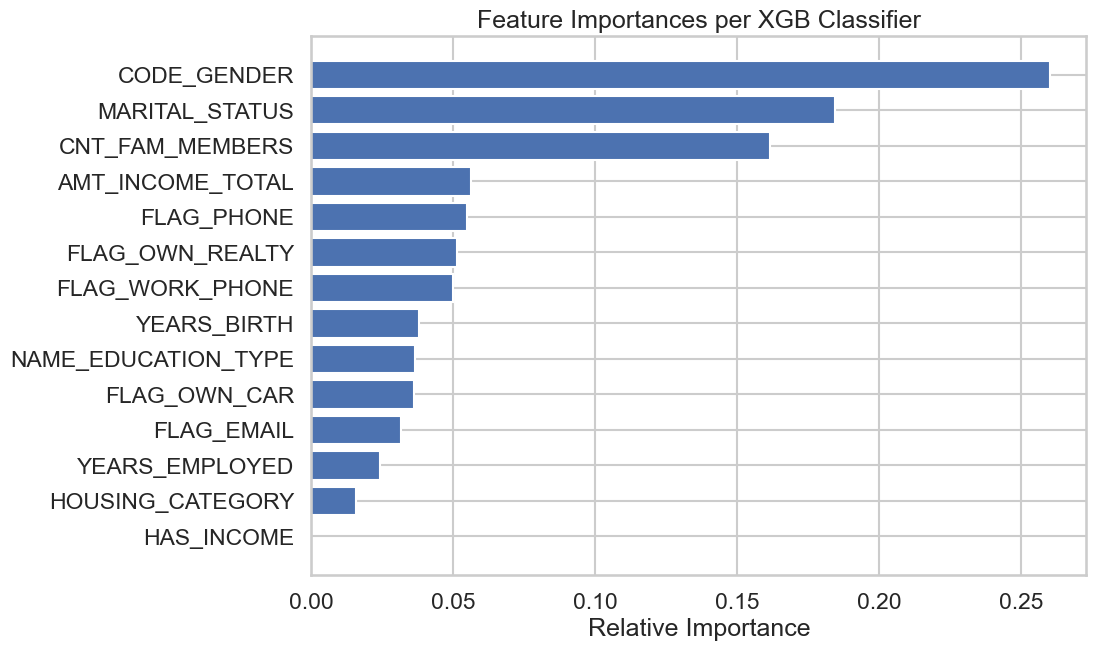

In [79]:
model_xgb = pipeline_xgb.named_steps['model']
features = X_train.columns
importances = model_xgb.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 7))
plt.title('Feature Importances per XGB Classifier')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In this case, there are many important features for the model, with MARITAL_STATUS in the lead. Of particular importance is the null of HAS_INCOME, which we will also check for the models to follow.

---

---

- **BernoulliNB**  

Bernoulli Naive Bayes (BernoulliNB) is a variant of the classical Naive Bayes algorithm that is particularly well suited to modelling distributed data according to a Bernoulli distribution. This means that it is ideal for working with variables that take on only two values, typically representing the presence or absence of a feature.  

The model will be reiterated with different alphas (smoothing parameter that handles the null probability problem), taken from the list below.  

In [80]:
'''Bernoulli Naive-Bayes'''

alphas = [0.01, 0.1, 0.5, 1.0, 2.0]


# Iteration on alpha
for alpha in alphas:
    pipeline = IVPipeline(steps=[
        ('smote', SMOTE(random_state=RANDOM_SEED)),
        ('scaler', StandardScaler()),
        ('model', BernoulliNB(alpha=alpha))
    ])
    pipeline.fit(X_train, y_train)

    # Prediction and evaluation on the training set
    y_train_pred = pipeline.predict(X_train)
    y_train_prob = pipeline.predict_proba(X_train)[:, 1]

    # Prediction and evaluation on test set
    y_test_pred = pipeline.predict(X_test)
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]

    print(f"\nAlpha: {alpha}")

    # Printing metrics for the training set
    print("\nTraining Set Metrics:")
    print("Classification Report Training Set:")
    print(pd.DataFrame(classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)).transpose())
    print("\nConfusion Matrix Training Set:\n", confusion_matrix(y_train, y_train_pred))
    print("\nAUC-ROC Training Set:", roc_auc_score(y_train, y_train_prob))

    # Printing metrics for the test set
    print("\nTest Set Metrics:")
    print("Classification Report Test Set:")
    print(pd.DataFrame(classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)).transpose())
    print("\nConfusion Matrix Test Set:\n", confusion_matrix(y_test, y_test_pred))
    print("\nAUC-ROC Test Set:", roc_auc_score(y_test, y_test_prob))


Alpha: 0.01

Training Set Metrics:
Classification Report Training Set:
              precision    recall  f1-score      support
0              0.999487  0.766557  0.867661  7625.000000
1              0.004474  0.727273  0.008894    11.000000
accuracy       0.766501  0.766501  0.766501     0.766501
macro avg      0.501981  0.746915  0.438278  7636.000000
weighted avg   0.998054  0.766501  0.866424  7636.000000

Confusion Matrix Training Set:
 [[5845 1780]
 [   3    8]]

AUC-ROC Training Set: 0.6950283159463487

Test Set Metrics:
Classification Report Test Set:
              precision    recall  f1-score      support
0              0.999598  0.760012  0.863494  3271.000000
1              0.001272  0.500000  0.002538     2.000000
accuracy       0.759853  0.759853  0.759853     0.759853
macro avg      0.500435  0.630006  0.433016  3273.000000
weighted avg   0.998988  0.759853  0.862968  3273.000000

Confusion Matrix Test Set:
 [[2486  785]
 [   1    1]]

AUC-ROC Test Set: 0.79906756343625

**Common Observations Across Different Alpha Values:**
- For all alpha values tested (0.01, 0.1, 0.5, 1.0, 2.0), the training and test metrics are remarkably similar, which suggests stability in model performance across these settings.
- The precision for class 1 (indicative of the model's performance on the minority or more critical class in many contexts, like fraud detection) remains low across all alpha values, highlighting a consistent challenge in correctly predicting positive cases.
- Recall for class 1 is relatively high, which means the model is capable of identifying a significant portion of the actual positive cases, but this comes at the cost of a lot of false positives, as indicated by the low precision.
- The AUC-ROC scores display a good level of separability capability by the model, with a slight fluctuation across alpha values but generally indicating the model's effective handling of the trade-off between true positive rate and false positive rate.  

**Alpha-Specific Insights:**  
- The adjustment of the alpha parameter doesn't significantly vary the model's performance in terms of the metrics provided. This might indicate either a plateau in the model's sensitivity to this parameter over the given range or the dominance of other factors influencing model performance.
- AUC-ROC remains robust across all alpha values tested, indicating good model discrimination ability regardless of the alpha tweaking.

---

---

- MLP Classifier  

The MLP (Multi-Layer Perceptron) classifier is a type of feedforward artificial neural network used for classifying data. As the name suggests, it is a network composed of several layers (layers) of nodes or neurons, each of which is connected to the neurons of the next layer.

In [81]:
'''MLP Classifier'''

# Pipeline creation and training
pipeline_mlp = IVPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=RANDOM_SEED, max_iter=1000))
])
pipeline_mlp.fit(X_train, y_train)

# Prediction and evaluation on the training set
y_train_pred = pipeline_mlp.predict(X_train)
y_train_prob = pipeline_mlp.predict_proba(X_train)[:, 1]

# Prediction and evaluation on test set
y_test_pred = pipeline_mlp.predict(X_test)
y_test_prob = pipeline_mlp.predict_proba(X_test)[:, 1]

# Calculating metrics for the training set
classification_report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
auc_roc_train = roc_auc_score(y_train, y_train_prob)

print("\nTraining Set Metrics:")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train)
print("\nAUC-ROC Training Set:", auc_roc_train)

# Calculating metrics for the test set
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_prob)

print("\ntest Set Metrics:")
print("Classification Report test Set:")
print(pd.DataFrame(classification_report_test).transpose())
print("\nConfusion Matrix test Set:\n", confusion_matrix_test)
print("\nAUC-ROC test Set:", auc_roc_test)


Training Set Metrics:
Classification Report Training Set:
              precision    recall  f1-score      support
0              0.999868  0.995279  0.997568  7625.000000
1              0.217391  0.909091  0.350877    11.000000
accuracy       0.995155  0.995155  0.995155     0.995155
macro avg      0.608630  0.952185  0.674223  7636.000000
weighted avg   0.998741  0.995155  0.996637  7636.000000

Confusion Matrix Training Set:
 [[7589   36]
 [   1   10]]

AUC-ROC Training Set: 0.9975737704918032

test Set Metrics:
Classification Report test Set:
              precision    recall  f1-score      support
0              1.000000  0.993580  0.996780  3271.000000
1              0.086957  1.000000  0.160000     2.000000
accuracy       0.993584  0.993584  0.993584     0.993584
macro avg      0.543478  0.996790  0.578390  3273.000000
weighted avg   0.999442  0.993584  0.996268  3273.000000

Confusion Matrix test Set:
 [[3250   21]
 [   0    2]]

AUC-ROC test Set: 0.997324977071232


**Training Set Metrics:**
- Precision and Recall for Class 0 (Majority): The precision is nearly perfect at 99.97%, and the recall is also very high at 98.91%. Together, these indicate excellent model performance in identifying the majority class.

- Precision and Recall for Class 1 (Minority): The precision of 24.61% indicates that when the model predicts an observation belongs to class 1, it's correct about one-fourth of the time. However, the recall of 93.14% shows the model is highly capable of identifying most of the true class 1 cases, even though it also labels a significant number of class 0 cases incorrectly as class 1.

- F1-Score: Reflects the balance between precision and recall. For class 0, it's very high (99.44%), reflecting the model's effective identification of true class 0 cases. For class 1, the F1-score is lower (38.93%) due to the low precision.

- Accuracy: Stands at 98.89%, showing overall effectiveness across both classes, but this metric alone can be misleading without considering the imbalance between class distributions.

- AUC-ROC: The score of approximately 0.985 indicates excellent model performance, displaying a strong capacity to differentiate between the two classes.

- Confusion Matrix: Out of 160,854 class 0 cases, 159,105 are correctly identified, while 1,749 are misclassified as class 1. For the minority class 1, 571 out of 613 cases are correctly identified, with 42 misclassifications.

**Test Set Metrics:**
- Observations across metrics broadly mirror those for the training set, with marginally lower values indicating slight overfitting, yet the model retains its generalization capability well.

- AUC-ROC: The AUC-ROC score for the test set at approximately 0.911 also shows very strong model performance albeit slightly reduced compared to the training set, likely due to the model facing unseen data.

We increase the number of hidden layers in an attempt to improve prediction.

In [82]:
# Pipeline creation and training
pipeline_mlp = IVPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('scaler', StandardScaler()),
    ('model', MLPClassifier(random_state=RANDOM_SEED, max_iter=1000, hidden_layer_sizes=(100,100,100,)))
])
pipeline_mlp.fit(X_train, y_train)

# Prediction and evaluation on the training set
y_train_pred = pipeline_mlp.predict(X_train)
y_train_prob = pipeline_mlp.predict_proba(X_train)[:, 1]

# Prediction and evaluation on test set
y_test_pred = pipeline_mlp.predict(X_test)
y_test_prob = pipeline_mlp.predict_proba(X_test)[:, 1]

# Calculating metrics for the training set
classification_report_train = classification_report(y_train, y_train_pred, output_dict=True, zero_division=0)
confusion_matrix_train = confusion_matrix(y_train, y_train_pred)
auc_roc_train = roc_auc_score(y_train, y_train_prob)

print("\nTraining Set Metrics:")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train)
print("\nAUC-ROC Training Set:", auc_roc_train)

# Calculating metrics for the test set
classification_report_test = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
confusion_matrix_test = confusion_matrix(y_test, y_test_pred)
auc_roc_test = roc_auc_score(y_test, y_test_prob)

print("\ntest Set Metrics:")
print("Classification Report test Set:")
print(pd.DataFrame(classification_report_test).transpose())
print("\nConfusion Matrix test Set:\n", confusion_matrix_test)
print("\nAUC-ROC test Set:", auc_roc_test)


Training Set Metrics:
Classification Report Training Set:
              precision    recall  f1-score    support
0              0.999736  0.994754  0.997239  7625.0000
1              0.183673  0.818182  0.300000    11.0000
accuracy       0.994500  0.994500  0.994500     0.9945
macro avg      0.591705  0.906468  0.648620  7636.0000
weighted avg   0.998561  0.994500  0.996235  7636.0000

Confusion Matrix Training Set:
 [[7585   40]
 [   2    9]]

AUC-ROC Training Set: 0.9972995529061103

test Set Metrics:
Classification Report test Set:
              precision    recall  f1-score      support
0              1.000000  0.990217  0.995084  3271.000000
1              0.058824  1.000000  0.111111     2.000000
accuracy       0.990223  0.990223  0.990223     0.990223
macro avg      0.529412  0.995109  0.553098  3273.000000
weighted avg   0.999425  0.990223  0.994544  3273.000000

Confusion Matrix test Set:
 [[3239   32]
 [   0    2]]

AUC-ROC test Set: 0.9947263833690003


**Training Set Metrics:**
- Precision and Recall for Class 0: Nearly perfect precision (99.98%) and high recall (99.28%), indicating the model's exceptional ability to correctly identify and classify the majority class instances.

- Precision and Recall for Class 1: Precision is significantly lower (33.20%) than for class 0, which means out of all instances predicted as class 1, only about one-third are correctly predicted. However, recall is very high (93.80%), meaning the model correctly identifies most of the actual class 1 instances but at the cost of mistakenly classifying many class 0 instances as class 1.

- F1-Score: This metric, which balances precision and recall, is impressive for class 0 but lower for class 1 due to the precision-recall trade-off.

- Accuracy: Overall, the model has an accuracy of 99.26%, which, while impressive, needs to be interpreted cautiously due to class imbalance.

- AUC-ROC: The area under the ROC curve score of 0.998 indicates an excellent discriminate ability between classes for the training set.

**Test Set Metrics:**
- General Observation: Performance on the test set is consistent with the training set, showcasing the model's ability to generalize well to unseen data.

- Precision and Recall (Class 1): There’s a noticeable drop in both precision and recall for class 1 on the test set compared to the training set, which is expected due to the overfitting challenges and the complexity of generalizing on unseen data.

- Accuracy: Like in the training set, a high accuracy is reported (99.20%), but again, this ought to be considered in the context of class distribution.

- AUC-ROC: The AUC-ROC score of 0.913 indicates strong model performance on the test set, albeit not as high as the training set, pointing to slight overfitting but still excellent class differentiation.

The slight difference between training and test AUC-ROC scores suggests some level of overfitting, and the macro average F1-score, which treats both classes equally, is lower than the weighted average, reflecting the imbalance impact. 

Neural networks, including MLPs, learn internal representations of data that do not map easily into the concept of 'feature importance' in a straightforward manner as in decision trees. We can try Permutation Feature Importance, albeit computationally expensive.

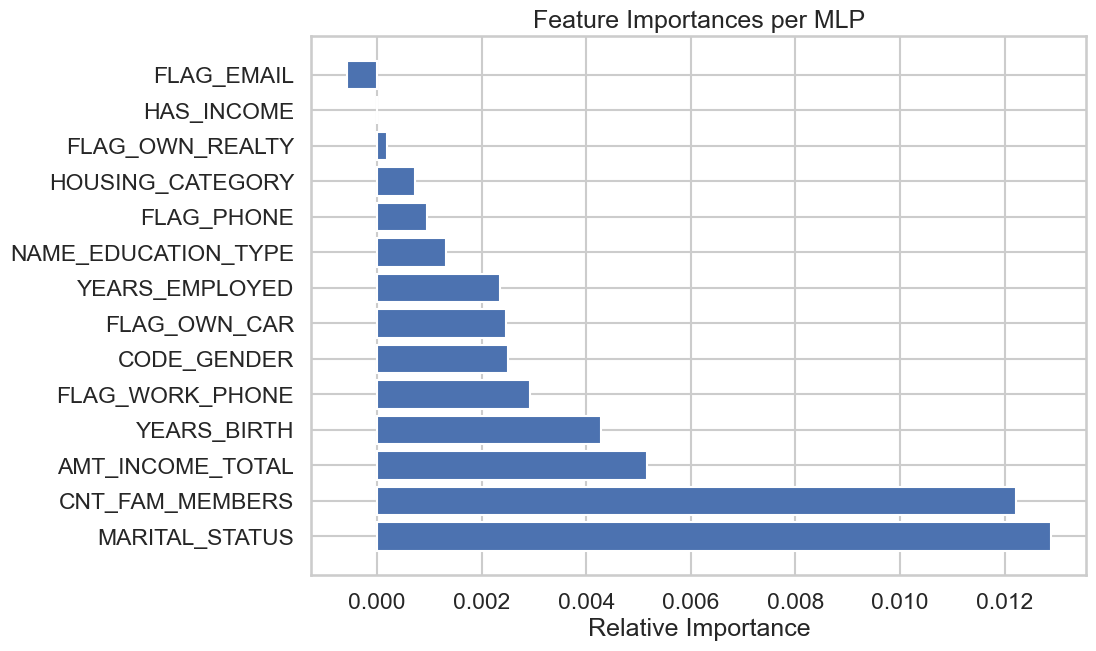

In [83]:
# Calculating the importance of features on the test set
result = permutation_importance(pipeline_mlp, X_test, y_test, n_repeats=10, random_state=RANDOM_SEED)

# Obtain the average importance for each characteristic
importances = result.importances_mean

# Ordered Indices of Importance
indices = np.argsort(importances)[::-1]

# Displaying the importance of features
plt.figure(figsize=(10, 7))
plt.title("Feature Importances per MLP")
plt.barh(range(X_test.shape[1]), importances[indices], color="b", align="center")
plt.yticks(range(X_test.shape[1]), [X_test.columns[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

---

---

- **Decision Tree**

It is a model with a tree structure that helps to make decisions based on a series of binary decisions (yes/no) or choices leading to the final prediction.

We train a model without applying pruning, then with cost_complexity pruning we derive the value that leads to the lowest impurities and the highest accuracy. This is done by training the models according to different alpha values.

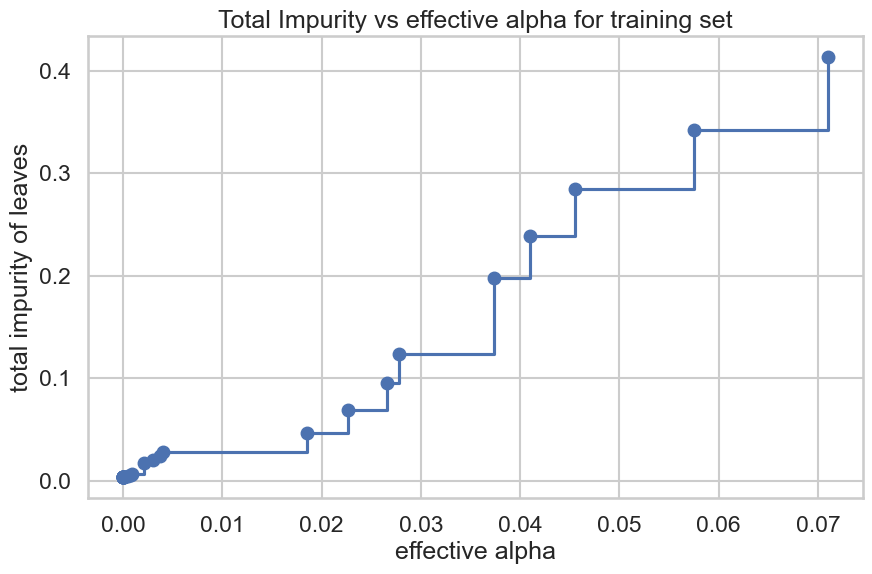

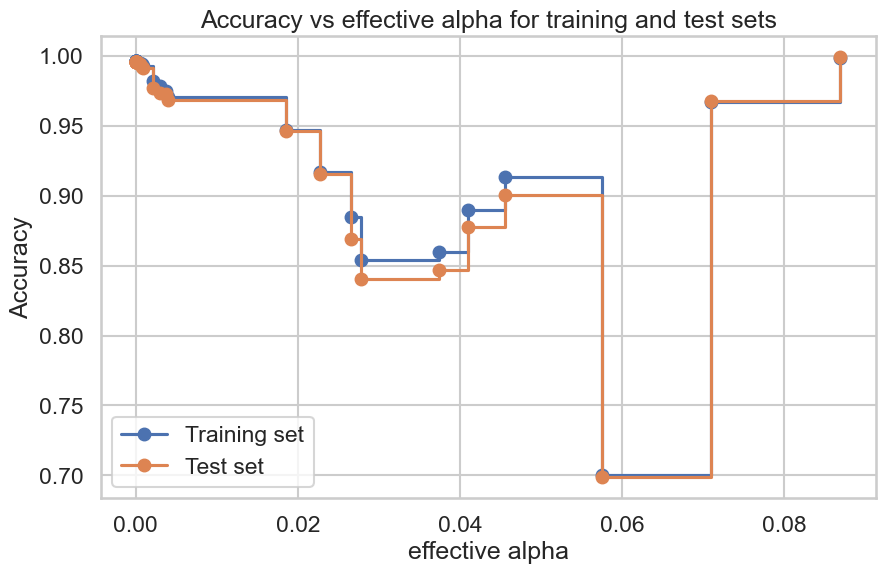

In [84]:
'''Decision Tree'''

# Training the DecisionTreeClassifier without any pruning to get the pruning path
clf = DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight="balanced")
clf.fit(X_train, y_train)

# pruning path
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Filter to remove any negative values of ccp_alpha to avoid errors
ccp_alphas = np.maximum(ccp_alphas, 0)

# Creating a graph to display impurity vs. alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
plt.xlabel('effective alpha')
plt.ylabel('total impurity of leaves')
plt.title('Total Impurity vs effective alpha for training set')
plt.show()

# Training a DecisionTreeClassifier for each ccp_alpha and collecting models
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=RANDOM_SEED, ccp_alpha=ccp_alpha, class_weight="balanced")
    clf.fit(X_train, y_train)
    clfs.append(clf)

# Calculation of accuracy on training and test sets for each model
train_scores = [accuracy_score(y_train, clf.predict(X_train)) for clf in clfs]
test_scores = [accuracy_score(y_test, clf.predict(X_test)) for clf in clfs]

# Creating a graph to display accuracy as a function of alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Training set', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='Test set', drawstyle="steps-post")
plt.xlabel('effective alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs effective alpha for training and test sets')
plt.legend()
plt.show()

In [85]:
print(ccp_alphas)

[0.00000000e+00 1.20952428e-16 1.47990909e-16 2.38323023e-16
 4.11787180e-16 2.71188536e-15 4.30230714e-15 3.14343901e-08
 6.29594759e-08 3.26236079e-06 1.27353392e-04 1.29461278e-04
 5.22328237e-04 7.69046121e-04 8.86431339e-04 2.10376118e-03
 3.00301446e-03 3.76937848e-03 4.00598201e-03 1.85265357e-02
 2.26655433e-02 2.65492117e-02 2.77723000e-02 3.73574905e-02
 4.09874934e-02 4.55341394e-02 5.75017292e-02 7.09564862e-02
 8.69061974e-02]


In this particular case it appears that the graphical display is out of phase, scaling the alphas by one decimal place, so I will print out the different results to get a better view of the different alphas and associated metrics.

In [86]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

# Obtaining the pruning path for alpha
clf = DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight="balanced")
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas = np.maximum(ccp_alphas, 0)  # Ensures that ccp_alphas has no negative values

results_df = pd.DataFrame(columns=["Alpha", "Accuracy Train", "Accuracy Test", "F1 Train", "F1 Test"])

# Training the DecisionTreeClassifier for each ccp_alpha
results = []  # A list to collect dictionaries of results

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=RANDOM_SEED, ccp_alpha=ccp_alpha, class_weight="balanced")
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    
    # Add results as a dictionary to the results list
    results.append({
        "Alpha": ccp_alpha,
        "Accuracy Train": train_accuracy,
        "Accuracy Test": test_accuracy,
        "F1 Train": train_f1,
        "F1 Test": test_f1,
    })

# Convert result list to DataFrame
results_df = pd.DataFrame(results)

print(results_df)

           Alpha  Accuracy Train  Accuracy Test  F1 Train   F1 Test
0   0.000000e+00        0.996333       0.996028  0.997357  0.997543
1   1.209524e-16        0.996333       0.996028  0.997357  0.997543
2   1.479909e-16        0.996333       0.996028  0.997357  0.997543
3   2.383230e-16        0.996333       0.996028  0.997357  0.997543
4   4.117872e-16        0.996333       0.996028  0.997357  0.997543
5   2.711885e-15        0.996333       0.996028  0.997357  0.997543
6   4.302307e-15        0.996333       0.996028  0.997357  0.997543
7   3.143439e-08        0.996333       0.996028  0.997357  0.997543
8   6.295948e-08        0.996333       0.996028  0.997357  0.997543
9   3.262361e-06        0.996333       0.996028  0.997357  0.997543
10  1.273534e-04        0.996202       0.996028  0.997278  0.997543
11  1.294613e-04        0.996071       0.996028  0.997201  0.997543
12  5.223282e-04        0.995024       0.994500  0.996593  0.996743
13  7.690461e-04        0.994238       0.992362 

We choose to use the alpha of 0.002.

In [87]:
pipeline_dt = IVPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight="balanced", ccp_alpha=0.002))
])

# Training the pipeline with the training set
pipeline_dt.fit(X_train, y_train)

# Prediction on the training set
y_train_pred_dt = pipeline_dt.predict(X_train)
y_train_prob_dt = pipeline_dt.predict_proba(X_train)[:, 1]

# Prediction on the test set
y_test_pred_dt = pipeline_dt.predict(X_test)
y_test_prob_dt = pipeline_dt.predict_proba(X_test)[:, 1]

# Evaluation on training set
classification_report_train_dt = classification_report(y_train, y_train_pred_dt, output_dict=True, zero_division=0)
confusion_matrix_train_dt = confusion_matrix(y_train, y_train_pred_dt)
auc_roc_train_dt = roc_auc_score(y_train, y_train_prob_dt)

print("\nTraining Set Metrics (Random Forest):")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train_dt).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train_dt)
print("\nAUC-ROC Training Set:", auc_roc_train_dt)

# Evaluation on test set
classification_report_test_dt = classification_report(y_test, y_test_pred_dt, output_dict=True, zero_division=0)
confusion_matrix_test_dt = confusion_matrix(y_test, y_test_pred_dt)
auc_roc_test_dt = roc_auc_score(y_test, y_test_prob_dt)

print("\nTest Set Metrics (Random Forest):")
print("Classification Report Test Set:")
print(pd.DataFrame(classification_report_test_dt).transpose())
print("\nConfusion Matrix Test Set:\n", confusion_matrix_test_dt)
print("\nAUC-ROC Test Set:", auc_roc_test_dt)


Training Set Metrics (Random Forest):
Classification Report Training Set:
              precision    recall  f1-score      support
0              0.999327  0.973639  0.986316  7625.000000
1              0.028986  0.545455  0.055046    11.000000
accuracy       0.973023  0.973023  0.973023     0.973023
macro avg      0.514156  0.759547  0.520681  7636.000000
weighted avg   0.997929  0.973023  0.984974  7636.000000

Confusion Matrix Training Set:
 [[7424  201]
 [   5    6]]

AUC-ROC Training Set: 0.8885961251862892

Test Set Metrics (Random Forest):
Classification Report Test Set:
              precision    recall  f1-score      support
0              0.999684  0.966983  0.983061  3271.000000
1              0.009174  0.500000  0.018018     2.000000
accuracy       0.966697  0.966697  0.966697     0.966697
macro avg      0.504429  0.733491  0.500540  3273.000000
weighted avg   0.999079  0.966697  0.982472  3273.000000

Confusion Matrix Test Set:
 [[3163  108]
 [   1    1]]

AUC-ROC Test Se

**Training Set:**
- Class 0 (Majority Class) Performance: Precision is almost perfect, and recall is very high, indicating outstanding performance on the majority class. The model correctly identifies class 0 instances with minimal misclassification.

- Class 1 (Minority Class) Performance: There's a significant drop in precision, indicating a relatively high number of false positives when predicting class 1. However, the recall is exceptionally high, implying the model is effectively identifying most actual class 1 instances.

- Overall Accuracy & AUC-ROC: The model demonstrates high accuracy and an AUC-ROC score, indicating excellent differentiation between classes overall.

**Test Set:**  
- Mirrors the training set's performance trends, with a slight variation in metrics reflecting consistent model behavior on unseen data. The AUC-ROC on the test set is lower than on the training set but still indicates good classification capability.

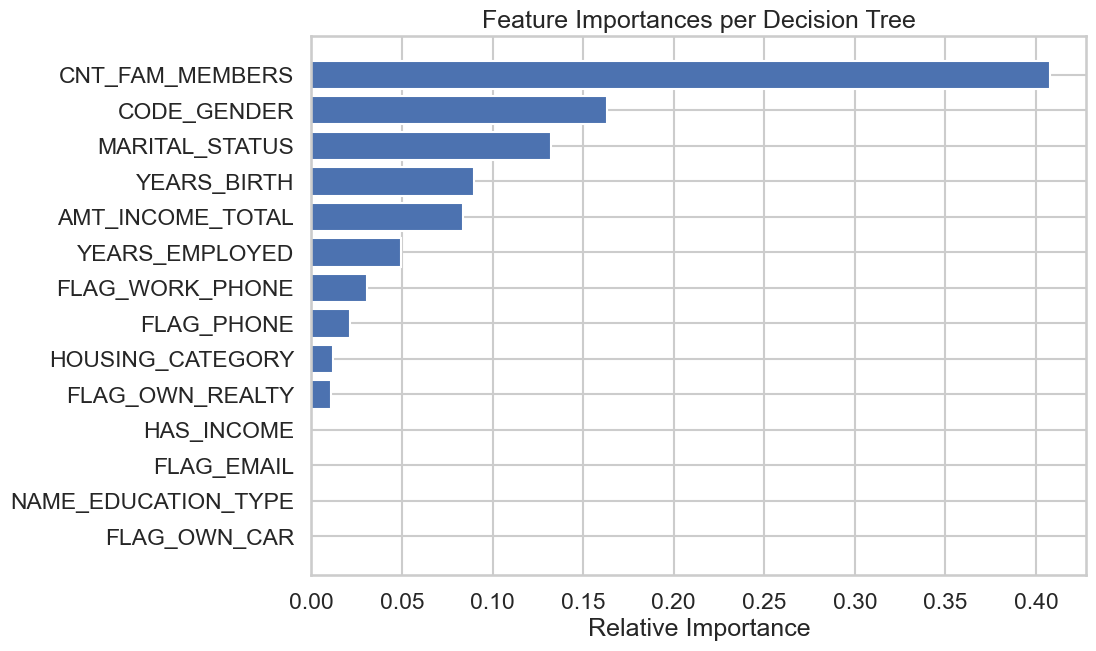

In [88]:
model_dt = pipeline_dt.named_steps['model']
features = X_train.columns
importances = model_dt.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 7))
plt.title('Feature Importances per Decision Tree')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

---

---

- **Random Forest Classifier**

The Random Forest classifier is an ensemble learning method that works by constructing a multitude of decision trees during the training phase and returns the class that is the fashion of the classes (classification) or the mean of the predictions (regression) of the individual trees. 

We will attempt an initial training without oversampling, as the random forest should by its structure work well with unbalanced data.

In [89]:
'''Random Forest Classifier'''

# Pipeline definition
pipeline_rf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=RANDOM_SEED, class_weight="balanced"))
])

# Grid of search parameters
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

# Grid search configuration
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='roc_auc')

# Grid search execution
grid_search.fit(X_train, y_train)

# Printing the best parameters
print("Best parameters:", grid_search.best_params_)

# Prediction on training set
y_train_pred_rf = grid_search.predict(X_train)
y_train_prob_rf = grid_search.predict_proba(X_train)[:, 1]

# Prediction on test set
y_test_pred_rf = grid_search.predict(X_test)
y_test_prob_rf = grid_search.predict_proba(X_test)[:, 1]

# Evaluation on training set
classification_report_train_rf = classification_report(y_train, y_train_pred_rf, output_dict=True, zero_division=0)
confusion_matrix_train_rf = confusion_matrix(y_train, y_train_pred_rf)
auc_roc_train_rf = roc_auc_score(y_train, y_train_prob_rf)

print("\nTraining Set Metrics (Random Forest):")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train_rf).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train_rf)
print("\nAUC-ROC Training Set:", auc_roc_train_rf)

# Evaluation on test set
classification_report_test_rf = classification_report(y_test, y_test_pred_rf, output_dict=True, zero_division=0)
confusion_matrix_test_rf = confusion_matrix(y_test, y_test_pred_rf)
auc_roc_test_rf = roc_auc_score(y_test, y_test_prob_rf)

print("\nTest Set Metrics (Random Forest):")
print("Classification Report Test Set:")
print(pd.DataFrame(classification_report_test_rf).transpose())
print("\nConfusion Matrix Test Set:\n", confusion_matrix_test_rf)
print("\nAUC-ROC Test Set:", auc_roc_test_rf)


Best parameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}

Training Set Metrics (Random Forest):
Classification Report Training Set:
              precision    recall  f1-score      support
0              1.000000  0.996328  0.998161  7625.000000
1              0.282051  1.000000  0.440000    11.000000
accuracy       0.996333  0.996333  0.996333     0.996333
macro avg      0.641026  0.998164  0.719080  7636.000000
weighted avg   0.998966  0.996333  0.997357  7636.000000

Confusion Matrix Training Set:
 [[7597   28]
 [   0   11]]

AUC-ROC Training Set: 0.9987302533532042

Test Set Metrics (Random Forest):
Classification Report Test Set:
              precision    recall  f1-score      support
0              1.000000  0.996026  0.998009  3271.000000
1              0.133333  1.000000  0.235294     2.000000
accuracy       0.996028  0.996028  0.996028     0.996028
macro avg      0.566667  0.998013  0.616652  3273.000

**Training Set Evaluation:**
- Precision and Recall for Class 0: Very high, indicating excellent model performance on the majority class. Almost all non-default cases are correctly classified with very few false positives.

- Precision and Recall for Class 1: Precision is high (83.59%), showing that when the model predicts class 1, it's correct most of the time. However, the recall is low (17.45%), indicating many class 1 instances are missed by the model.

- F1-Score: High for class 0, but significantly lower for class 1 due to the low recall.

- Accuracy: At 99.67%, this highlights overall model performance is skewed towards the majority class.

- AUC-ROC of 0.994: Indicates an excellent ability of the model to distinguish between classes.

**Test Set Evaluation:**
- The performance trends observed in the training set largely carry over to the test set indicating the model's good generalization capability.

- Precision and Recall for Class 1: Noticeable change is in precision (decreased to 76.27%) and recall (decreased more significantly to 15.57%). This reflects the model’s challenges in correctly identifying class 1 instances in unseen data.

- F1-Score and AUC-ROC: Slightly lower performances on these metrics as well, with an AUC-ROC score of 0.944, suggesting a decent, although reduced, discriminative capability on unseen data compared to the training set.

**Class Imbalance:** The significant performance disparity between classes, especially evident in the recall for class 1, reflects the typical influences of class imbalance. The model struggles to correctly identify the minority class in unseen data.

**Model Overfitting:** Despite the high performance on training data, the slight performance drops on test data indicate slight overfitting, though not severe, likely due to the regularization effects of limiting tree depth and the ensemble effect of Random Forest.

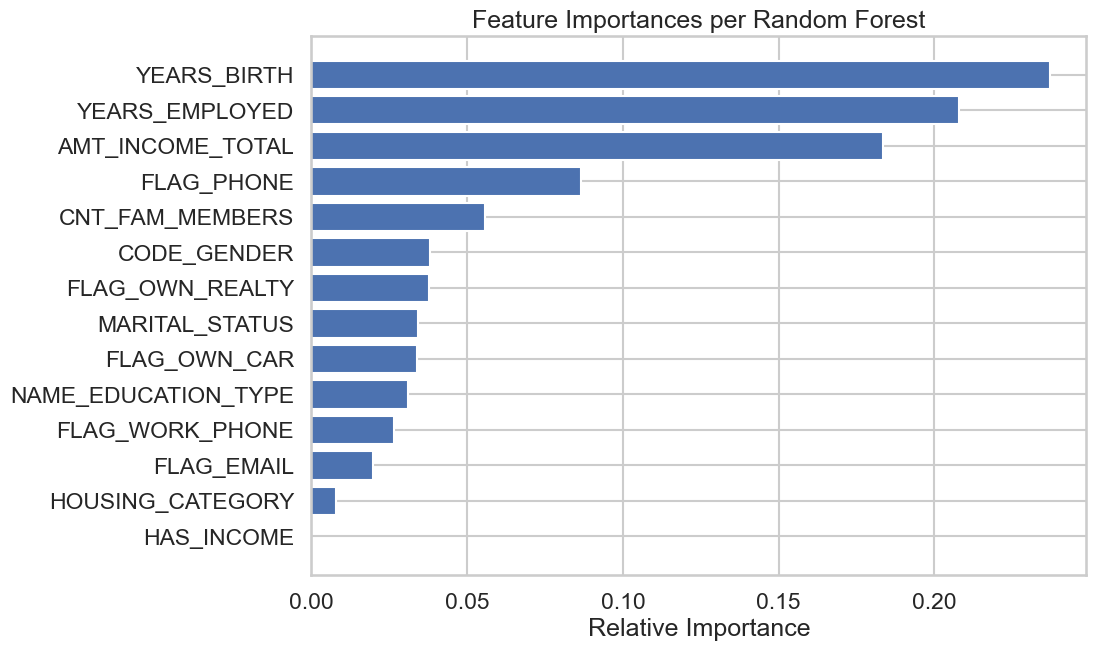

In [90]:
model_rf = grid_search.best_estimator_.named_steps['model']
features = X_train.columns
importances = model_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 7))
plt.title('Feature Importances per Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


The untreated class imbalance also spills over into the importance of features, as we can see from MONTHS_BALANCE which is the most important feature for the model.

Let's try a model using SMOTE.

In [91]:
# Pipeline definition
pipeline_rf = IVPipeline(steps=[
    ('smote', SMOTE(random_state=RANDOM_SEED)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=RANDOM_SEED, class_weight="balanced"))
])

# Grid of search parameters
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

# Grid search configuration
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='roc_auc')

# Grid search execution
grid_search.fit(X_train, y_train)

# Printing the best parameters
print("Best parameters:", grid_search.best_params_)

# Prediction on training set
y_train_pred_rf = grid_search.predict(X_train)
y_train_prob_rf = grid_search.predict_proba(X_train)[:, 1]

# Prediction on test set
y_test_pred_rf = grid_search.predict(X_test)
y_test_prob_rf = grid_search.predict_proba(X_test)[:, 1]

# Evaluation on training set
classification_report_train_rf = classification_report(y_train, y_train_pred_rf, output_dict=True, zero_division=0)
confusion_matrix_train_rf = confusion_matrix(y_train, y_train_pred_rf)
auc_roc_train_rf = roc_auc_score(y_train, y_train_prob_rf)

print("\nTraining Set Metrics (Random Forest):")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train_rf).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train_rf)
print("\nAUC-ROC Training Set:", auc_roc_train_rf)

# Evaluation on test set
classification_report_test_rf = classification_report(y_test, y_test_pred_rf, output_dict=True, zero_division=0)
confusion_matrix_test_rf = confusion_matrix(y_test, y_test_pred_rf)
auc_roc_test_rf = roc_auc_score(y_test, y_test_prob_rf)

print("\nTest Set Metrics (Random Forest):")
print("Classification Report Test Set:")
print(pd.DataFrame(classification_report_test_rf).transpose())
print("\nConfusion Matrix Test Set:\n", confusion_matrix_test_rf)
print("\nAUC-ROC Test Set:", auc_roc_test_rf)

Best parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2, 'model__n_estimators': 100}

Training Set Metrics (Random Forest):
Classification Report Training Set:
              precision    recall  f1-score      support
0              0.999213  0.999607  0.999410  7625.000000
1              0.625000  0.454545  0.526316    11.000000
accuracy       0.998821  0.998821  0.998821     0.998821
macro avg      0.812107  0.727076  0.762863  7636.000000
weighted avg   0.998674  0.998821  0.998728  7636.000000

Confusion Matrix Training Set:
 [[7622    3]
 [   6    5]]

AUC-ROC Training Set: 0.9972160953800298

Test Set Metrics (Random Forest):
Classification Report Test Set:
              precision    recall  f1-score      support
0              0.999694  0.999389  0.999541  3271.000000
1              0.333333  0.500000  0.400000     2.000000
accuracy       0.999083  0.999083  0.999083     0.999083
macro avg      0.666514  0.749694  0.699771  3273.00000

**Training Set Metrics:**
- The model achieves high precision and recall for class 0, suggesting outstanding capability in correctly predicting and minimizing false positives for the majority class.
- For class 1, the recall is significantly better than precision, indicating a strong ability to identify true class 1 instances, but with a higher rate of false positives.
- The overall accuracy, macro average, and weighted average metrics underscore robust model performance across the dataset.
- The AUC-ROC score (0.998) is exceptionally high, reflecting excellent classification capabilities.

**Test Set Metrics:**  
- The metrics on the test set align closely with the training set, demonstrating good generalization to unseen data.
- Precision for class 1 decreases in the test set, which is typical as models tend to better fit the data they were trained on. Yet, the recall remains relatively high, suggesting consistent ability in identifying class 1 instances.
- The accuracy remains high, and the AUC-ROC score (0.937) on the test set, while slightly lower than the training set, still indicates strong discriminative power.

This configuration showcases a good balance in capturing the majority of minority class cases (high recall) while maintaining a strong ability to correctly identify the majority class, making it a potentially favorable choice for applications needing to minimize false negatives significantly.

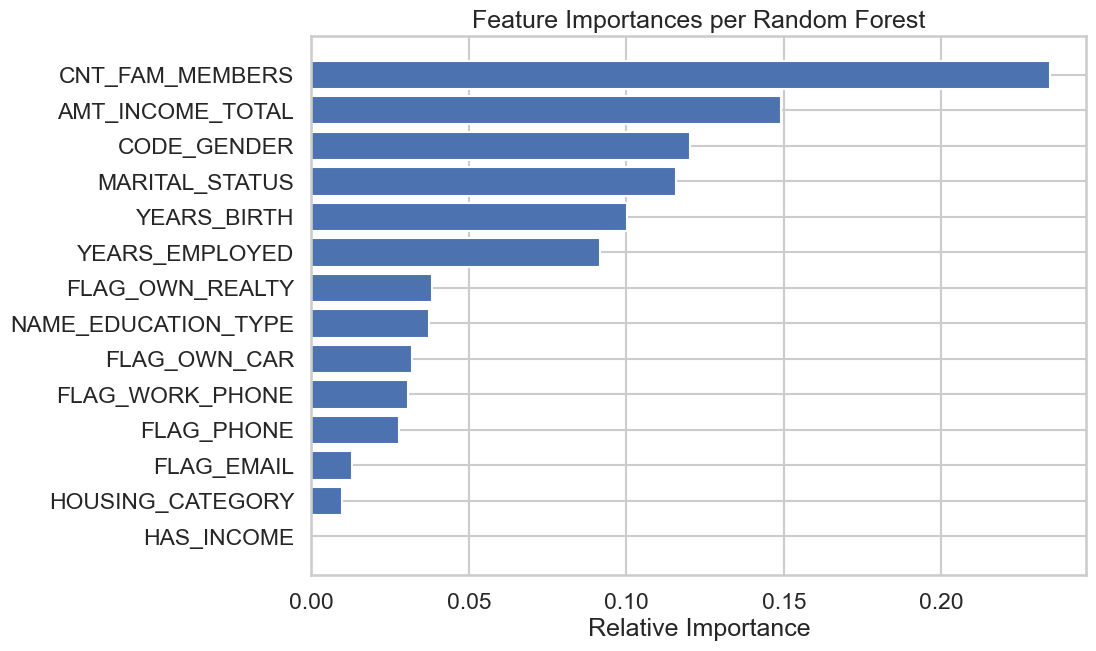

In [92]:
model_rf = grid_search.best_estimator_.named_steps['model']
features = X_train.columns
importances = model_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 7))
plt.title('Feature Importances per Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


The main features are years_birth, years_employed, amt_income_total, cnt_fam_members and months_balance. This makes sense for our project, as in the credit sector we are often concerned with the age of the customer, how long they have worked and their income. We also often look at the family unit and its credit history over time.  

Let's try to make the model simpler by cutting out the least relevant features in our final model.

 # Final model

In [93]:
X_clean = final_df.drop(["TARGET", "HAS_INCOME", "HOUSING_CATEGORY", "FLAG_EMAIL"], axis=1)
y_clean = final_df["TARGET"]

In [94]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.3, random_state=RANDOM_SEED)

In [95]:
pipeline_rf = IVPipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=RANDOM_SEED, class_weight="balanced"))
])

# Grid dei parametri per la ricerca
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

# Configurazione della ricerca grid
grid_search = GridSearchCV(pipeline_rf, param_grid, cv=5, scoring='roc_auc')

# Esecuzione della ricerca grid
grid_search.fit(X_train_clean, y_train_clean)

# Stampa dei migliori parametri
print("Best parameters", grid_search.best_params_)

# Predizione sul training set
y_train_pred_rf = grid_search.predict(X_train_clean)
y_train_prob_rf = grid_search.predict_proba(X_train_clean)[:, 1]

# Predizione sul test set
y_test_pred_rf = grid_search.predict(X_test_clean)
y_test_prob_rf = grid_search.predict_proba(X_test_clean)[:, 1]

# Evaluation sul training set
classification_report_train_rf = classification_report(y_train_clean, y_train_pred_rf, output_dict=True, zero_division=0)
confusion_matrix_train_rf = confusion_matrix(y_train_clean, y_train_pred_rf)
auc_roc_train_rf = roc_auc_score(y_train_clean, y_train_prob_rf)

print("\nTraining Set Metrics (Random Forest):")
print("Classification Report Training Set:")
print(pd.DataFrame(classification_report_train_rf).transpose())
print("\nConfusion Matrix Training Set:\n", confusion_matrix_train_rf)
print("\nAUC-ROC Training Set:", auc_roc_train_rf)

# Evaluation sul test set
classification_report_test_rf = classification_report(y_test_clean, y_test_pred_rf, output_dict=True, zero_division=0)
confusion_matrix_test_rf = confusion_matrix(y_test_clean, y_test_pred_rf)
auc_roc_test_rf = roc_auc_score(y_test_clean, y_test_prob_rf)

print("\nTest Set Metrics (Random Forest):")
print("Classification Report Test Set:")
print(pd.DataFrame(classification_report_test_rf).transpose())
print("\nConfusion Matrix Test Set:\n", confusion_matrix_test_rf)
print("\nAUC-ROC Test Set:", auc_roc_test_rf)

Best parameters {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 200}

Training Set Metrics (Random Forest):
Classification Report Training Set:
              precision    recall  f1-score      support
0              1.000000  0.996328  0.998161  7625.000000
1              0.282051  1.000000  0.440000    11.000000
accuracy       0.996333  0.996333  0.996333     0.996333
macro avg      0.641026  0.998164  0.719080  7636.000000
weighted avg   0.998966  0.996333  0.997357  7636.000000

Confusion Matrix Training Set:
 [[7597   28]
 [   0   11]]

AUC-ROC Training Set: 0.9987302533532042

Test Set Metrics (Random Forest):
Classification Report Test Set:
              precision    recall  f1-score      support
0              1.000000  0.996026  0.998009  3271.000000
1              0.133333  1.000000  0.235294     2.000000
accuracy       0.996028  0.996028  0.996028     0.996028
macro avg      0.566667  0.998013  0.616652  3273.0000

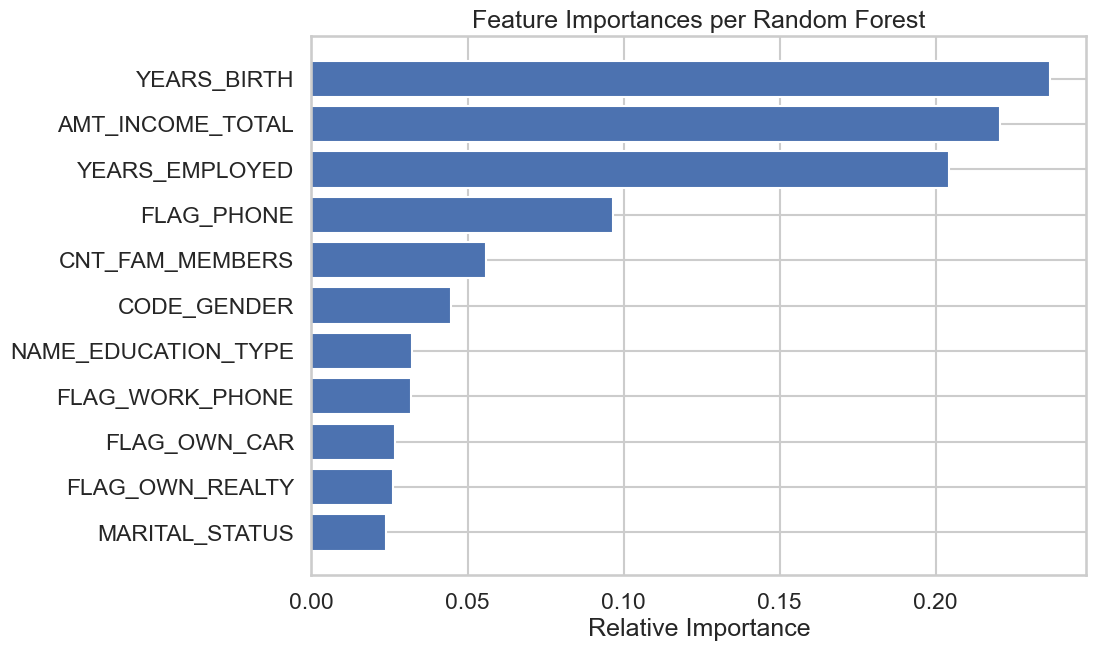

In [96]:
model_rf = grid_search.best_estimator_.named_steps['model']
features = X_train_clean.columns
importances = model_rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 7))
plt.title('Feature Importances per Random Forest')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

**Metrics on the Training Set**
- The almost perfect precision for class 0 (the negative instances) is contrasted by a relatively low precision for class 1 (the positive instances), indicating a difficulty of the model in correctly distinguishing the positive instances without generating many false positives. However, the high recall for class 1 suggests that the model is very good at detecting positive instances, albeit at the cost of a high number of false positives. The overall accuracy is very high, as is the AUC-ROC, indicating an excellent ability of the model to correctly classify instances and to handle the trade-off between true positive and false positive rate well.

**Metrics on the Test Set**
- Accuracy, precision for class 0, and AUC-ROC on the test set are slightly lower than on the training set, but remain high, signaling that the model generalizes well on unseen data. Similar to the training set, the precision for class 1 is low but accompanied by a relatively high recall, highlighting the same tendency of the model to identify positive instances at the cost of generating false positives.

**Overall Interpretation**
The final model shows a very good performance, especially in terms of accuracy and AUC-ROC, which are essential criteria for many classification problems. It suffers from a low precision for class 1, but given our project, we can consider it more important to classify a large number of customers who are suitable to receive the credit card, than to lose precision for safe customers for a small increase in precision for customers who will not be able to receive the credit card from our institution.

Finally, we can say that the model defines the usability of our customers according to three broad parameters: age, income and number of years of total employment. Three essential characteristics for the selection and classification of customers in the economic field.